In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import defaultdict
from scipy.optimize import minimize
import time as tm

## Optimizing using GD and artificial data

In [2]:
def utility_function(risk_factor, portfolio_return):
    value = ((1 + portfolio_return)**(1-risk_factor))/(1-risk_factor)
    return value

In [3]:
def utility_function_grad(r_p, gamma, r_p_grad):
    u_grad = np.power((1+r_p),-gamma) * r_p_grad
    return u_grad

## Optimization formula:
## $\underset{\theta}{\max} \frac{1}{T} \sum^{T-1}_{t=0} u\left( \sum_{i=1}^{N_{t}}( \bar{w}_{i,t} + \frac{1}{N_{t}}\theta^{\text{T}} \hat{x}_{i,t} ) r_{i,t+1} \right) $

## Critical point of formula:

## $ \frac{1}{T} \sum^{T-1}_{t=0} u'(r_{p,t+1}) \frac{1}{N_{t}}\hat{x}_{t}^{\text{T}} r_{t+1} = 0 $


## Utility function

## $u(r_{p,t+1}) = \frac{(1+r_{p,t+1})^{1-\gamma}}{1-\gamma} $

## Portfolio return
## $ r_{p,t+1} = \sum^{N_{t}}_{i=1} \bar{w}_{i,t} r_{i,t+1} + \sum^{N_{t}}_{i=1} (  \frac{1}{N_{t}} \theta^{\text{T}} \hat{x}_{i,t} ) r_{i,t+1} $


## Utility function derivate

## $u'(r_{p,t+1}) = (1+r_{p, t+1})^{-\gamma} r'_{p, t+1} $

## Portfolio return derivate
## $ r'_{p,t+1} = \sum^{N_{t}}_{i=1} (  \frac{1}{N_{t}} \hat{x}_{i,t} ) r_{i,t+1} = \frac{1}{N_{t}}\hat{x}_{t}^{\text{T}} r_{t+1} $

## Critical point expanded:
## $ \frac{1}{T} \sum^{T-1}_{t=0} u'(r_{p,t+1}) \frac{1}{N_{t}}\hat{x}_{t}^{\text{T}} r_{t+1} = 0 $
## $ \frac{1}{T} \sum^{T-1}_{t=0} (1+r_{p, t+1})^{-\gamma} r'_{p, t+1} \frac{1}{N_{t}}\hat{x}_{t}^{\text{T}} r_{t+1} = 0 $
## $ \frac{1}{T} \sum^{T-1}_{t=0} (1+r_{p, t+1})^{-\gamma} (r'_{p, t+1})^2 $

In [10]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.5f}".format(x)})

time = 90 # 90 days
number_of_stocks = 10
np.random.seed(123)
r = np.empty(shape=(number_of_stocks,time))
gamma = 5
firm_characteristics = defaultdict(list)
# random initialization of theta for 3 firm characteristics
w = np.empty(shape=(number_of_stocks, time))
# Learning rate
lr = 1e-3
epochs = 5000
return_all = []

# Creating artificial return
for i in range(number_of_stocks):
    for t in range(time):
        # Toy firm characteristics
        if i>=5:
            # Negative return firms
            me = np.random.uniform(0,1)
            btm = np.random.uniform(-1,0)
            mom = np.random.uniform(-1,0)
        else:
            # Positive return firms
            me = np.random.uniform(-1,0)
            btm = np.random.uniform(0,1)
            mom = np.random.uniform(0,1)
#         me = np.random.uniform(-1,1)
#         btm = np.random.uniform(-1,1)
#         mom = np.random.uniform(-1,1)
            
        firm_characteristics[(i,'me')].append(me)
        firm_characteristics[(i,'btm')].append(btm)
        firm_characteristics[(i,'mom')].append(mom)
        # simplified weight using only firm characteristics
        # return of portifolio i at time t
        r[i][t] = (-0.337*me + 3.553*btm + 1.623*mom)

print("Created all artificial stocks")
firm_characteristics = pd.DataFrame(firm_characteristics)
# Normalize firm characteristics for each stock
firm_characteristics.T.loc[(slice(None), "me"), :] -= firm_characteristics.T.loc[(slice(None), "me"), :].mean()
firm_characteristics.T.loc[(slice(None), "btm"), :] -= firm_characteristics.T.loc[(slice(None), "btm"), :].mean()
firm_characteristics.T.loc[(slice(None), "mom"), :] -= firm_characteristics.T.loc[(slice(None), "mom"), :].mean()

Created all artificial stocks


In [11]:
# Creating a weight from a benchmark portifolio this one
# specific is related to return of each stock for simplicity
w_benchmark = np.empty(shape=(number_of_stocks, time))
epsilon=1e-5
for t in range(time):
    positive_returns = (r[:,t]-min(r[:,t]))+epsilon
    w_benchmark[:,t] = positive_returns/sum(positive_returns)

In [12]:
np.random.seed(123)
theta = np.random.rand(1, 3)
for k in tqdm(range(epochs)):
    r_p_grad=0
    r_p = 0
    # Optmize Theta over all stocks and times
#     print(f" Theta :{theta}, k:{k}")
    for i in range(number_of_stocks):
        firm_df = firm_characteristics[i].copy()
        firms_coeff = theta.dot(firm_df.T)
        # Multiply only t-1 firm characteristics
        # Starting return r at t+1
        r_p_grad += firm_df[:-1].T * r[i, 1:]
        r_p +=  w_benchmark[i,:-1]*r[i, 1:] + (1/number_of_stocks)*firms_coeff[:,:-1]*r[i, 1:]
    r_p_grad *= (1/number_of_stocks)
    u_grad = utility_function_grad(r_p, gamma, r_p_grad)
    # It will be changed with u_grad
    gradient = (r_p_grad * u_grad).T.sum()/time
#     print(f" Gradient :{gradient.to_numpy()}, k:{k}\n")
    theta += lr * gradient

    
    # Avaliate function
    for i in range(number_of_stocks):
        firm_df = firm_characteristics[i].copy()
        firms_coeff = theta.dot(firm_df.T)
        w[i] = w_benchmark[i] + (1/number_of_stocks)*firms_coeff
    
    # Using t-1 weights and r from 1 to t
    r_p = sum(w[:,:-1]*r[:,1:])
    utility_values = utility_function(5, r_p)
    # Average over T 
    average_return_portifolio = sum(utility_values)/len(utility_values)
    return_all.append(average_return_portifolio)
#     print(f"Return {average_return_portifolio}")
print(f"Finished running {epochs} epochs")


Finished running 5000 epochs


In [23]:
np.sum(w, axis=1)/time

array([0.16143, 0.16431, 0.16957, 0.15279, 0.15868, 0.04073, 0.04327,
       0.03851, 0.03118, 0.03953])

In [14]:
pd.DataFrame(return_all).describe()

,0
count,5000.000000
mean,-0.008991
std,0.000094
min,-0.009211
25%,-0.009060
50%,-0.008959
75%,-0.008906
max,-0.008897


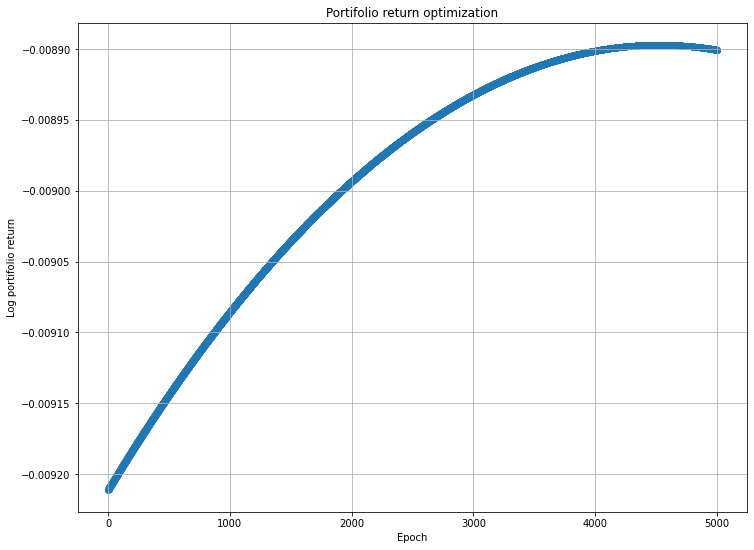

In [15]:
plt.figure(figsize=(12,9))
# plt.yscale('symlog')
plt.scatter(x=range(len(return_all)), y=return_all)
plt.title('Portifolio return optimization')
plt.ylabel('Log portifolio return')
plt.xlabel('Epoch')
plt.grid()
plt.show()

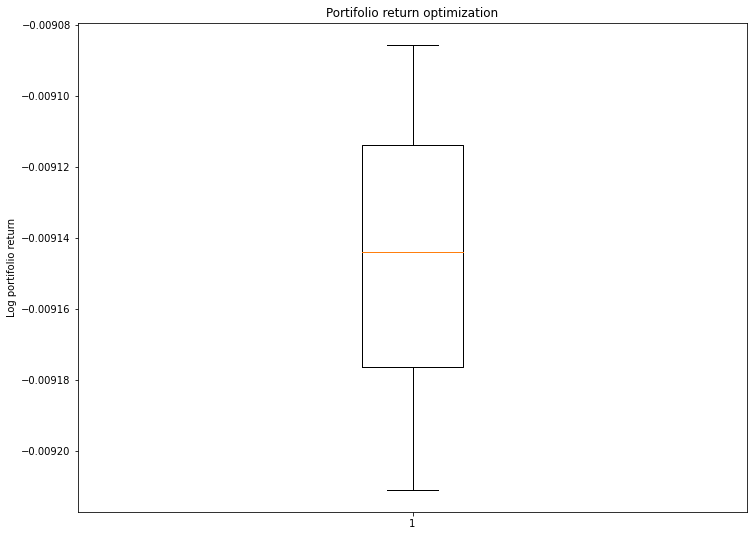

In [231]:
plt.figure(figsize=(12,9))
# plt.yscale('symlog')
plt.boxplot(return_all)
plt.title('Portifolio return optimization')
plt.ylabel('Log portifolio return')
plt.show()

## Using scipy to optimize easily and to add constraints

In [12]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.5f}".format(x)})

time = 90 # 4000 days
number_of_stocks = 10
np.random.seed(123)
r = np.empty(shape=(number_of_stocks,time))
gamma = 5
firm_characteristics = defaultdict(list)
# Learning rate
lr = 1e-3
epochs = 5000
return_all = []

# Creating artificial return
for i in range(number_of_stocks):
    for t in range(time):
        # Toy firm characteristics
        if i>=5:
            # Negative return firms
            me = np.random.uniform(0,1)
            btm = np.random.uniform(-1,0)
            mom = np.random.uniform(-1,0)
        else:
            # Positive return firms
            me = np.random.uniform(-1,0)
            btm = np.random.uniform(0,1)
            mom = np.random.uniform(0,1)
#         me = np.random.uniform(-1,1)
#         btm = np.random.uniform(-1,1)
#         mom = np.random.uniform(-1,1)
            
        firm_characteristics[(i,'me')].append(me)
        firm_characteristics[(i,'btm')].append(btm)
        firm_characteristics[(i,'mom')].append(mom)
        # simplified weight using only firm characteristics
        # return of portifolio i at time t
        r[i][t] = (-0.337*me + 3.553*btm + 1.623*mom)

print("Created all artificial stocks")
firm_characteristics = pd.DataFrame(firm_characteristics)
# Normalize firm characteristics for each stock
firm_characteristics.T.loc[(slice(None), "me"), :] -= firm_characteristics.T.loc[(slice(None), "me"), :].mean()
firm_characteristics.T.loc[(slice(None), "btm"), :] -= firm_characteristics.T.loc[(slice(None), "btm"), :].mean()
firm_characteristics.T.loc[(slice(None), "mom"), :] -= firm_characteristics.T.loc[(slice(None), "mom"), :].mean()

Created all artificial stocks


In [13]:
# Creating a weight from a benchmark portifolio this one
# specific is related to return of each stock for simplicity
w_benchmark = np.empty(shape=(number_of_stocks, time))
epsilon=1e-5
for t in range(time):
    positive_returns = (r[:,t]-min(r[:,t]))+epsilon
    w_benchmark[:,t] = positive_returns/sum(positive_returns)

In [14]:
def utility_function(risk_factor, portfolio_return):
    value = ((1 + portfolio_return)**(1-risk_factor))/(1-risk_factor)
    return value

In [52]:
time = 90
def objective(theta): 
    w = np.empty(shape=(number_of_stocks, time))
    for i in range(number_of_stocks):
        w[i] = w_benchmark[i] + (1/number_of_stocks)*theta.dot(firm_characteristics[i].copy().T)
    
    return -sum(sum(utility_function(5, w[:,:-1]*r[:,1:])))/time

In [48]:
np.random.seed(123)
theta0 = np.random.rand(1, 3)
theta0

array([[0.69647, 0.28614, 0.22685]])

In [17]:
from scipy.optimize import minimize

In [55]:
opt_iter = 1
mean_obj_r = []
mean_r = []
def callback_steps(thetaI):
    global opt_iter
    print(f"i:{opt_iter}, theta i: {thetaI}, f(theta):{objective(thetaI)}")
    mean_obj_r.append(-objective(thetaI))
    
    w_iter = np.empty(shape=(number_of_stocks, time))
    for i in range(number_of_stocks):
        w_iter[i] = w_benchmark[i] + (1/number_of_stocks)*thetaI.dot(firm_characteristics[i].copy().T)
    mean_r.append(sum(sum(w_iter*r)))
    
    opt_iter += 1

In [56]:
sol = minimize(objective, theta0, callback=callback_steps)
sol

i:1, theta i: [-0.06351 0.70841 0.74088], f(theta):1.2131658535421985
i:2, theta i: [-0.20432 0.90021 0.93178], f(theta):0.9978152325831017
i:3, theta i: [-0.52549 1.36168 1.38148], f(theta):0.6731738839743524
i:4, theta i: [-0.91579 1.94000 1.93716], f(theta):0.451484515895554
i:5, theta i: [-1.39522 2.65933 2.62362], f(theta):0.3002525460209777
i:6, theta i: [-1.98102 3.54260 3.46382], f(theta):0.1983528425988593
i:7, theta i: [-2.69483 4.62088 4.48809], f(theta):0.1301370450768914
i:8, theta i: [-3.56019 5.92892 5.72992], f(theta):0.08483774706203423
i:9, theta i: [-4.60438 7.50756 7.22839], f(theta):0.054968658415998156
i:10, theta i: [-5.85825 9.40331 9.02778], f(theta):0.03541244184901504
i:11, theta i: [-7.35715 11.66955 11.17886], f(theta):0.022691391987925764
i:12, theta i: [-9.14152 14.36743 13.73968], f(theta):0.014466088600210095
i:13, theta i: [-11.25767 17.56695 16.77670], f(theta):0.009176830512822358
i:14, theta i: [-13.75844 21.34802 20.36577], f(theta):0.0057930025887

      fun: 0.00033151769537402044
 hess_inv: array([[141944.34195, -214613.46502, -203717.71370],
       [-214613.46502, 324488.78434, 308013.86671],
       [-203717.71370, 308013.86671, 292377.30351]])
      jac: array([0.00001, -0.00000, -0.00001])
  message: 'Optimization terminated successfully.'
     nfev: 84
      nit: 20
     njev: 21
   status: 0
  success: True
        x: array([-40.71603, 62.10689, 59.05532])

In [20]:
sol_theta = sol.x
w_sol = np.empty(shape=(number_of_stocks, time))
for i in range(number_of_stocks):
    firm_df = firm_characteristics[i].copy()
    firms_coeff = sol_theta.dot(firm_df.T)
    w_sol[i] = w_benchmark[i] + (1/number_of_stocks)*firms_coeff

In [28]:
np.sum(w_sol, axis=1)/time

array([8.31961, 8.38071, 8.25111, 7.94663, 8.36792, -8.06084, -7.75736,
       -8.13767, -8.13713, -8.17299])

In [44]:
sum(sum(w_benchmark*r))

190.9346282688151

In [45]:
sum(sum(w_sol*r))

22450.27196617353

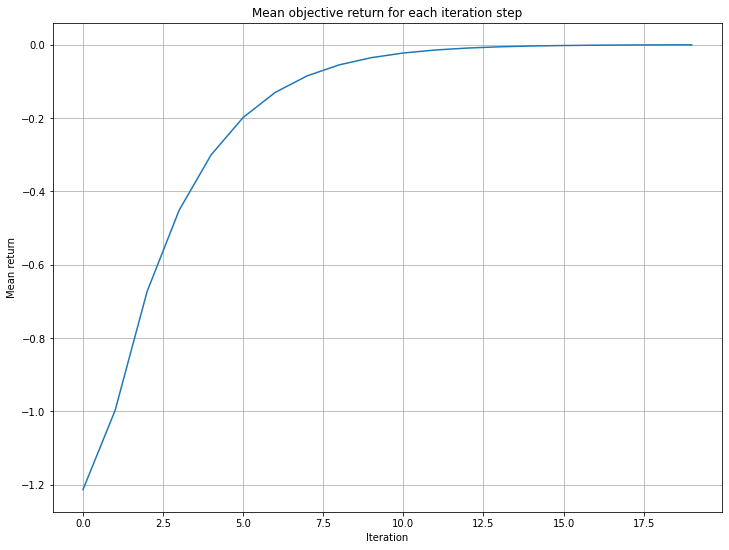

In [68]:
x = range(len(mean_obj_r))
plt.figure(figsize=(12,9))
plt.title("Mean objective return for each iteration step")
plt.plot(x, mean_obj_r)
plt.xlabel('Iteration')
plt.ylabel('Mean return')
plt.grid()
plt.show()

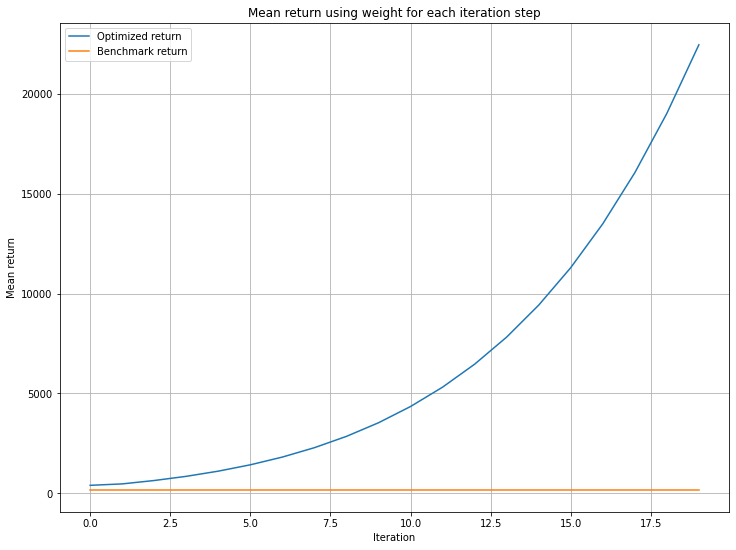

In [70]:
x = range(len(mean_r))
plt.figure(figsize=(12,9))
plt.title("Mean return using weight for each iteration step")
plt.plot(x, mean_r, label='Optimized return')
plt.plot(x, [sum(sum(w_benchmark*r))]*len(x), label='Benchmark return')
plt.xlabel('Iteration')
plt.ylabel('Mean return')
plt.legend()
plt.grid()
plt.show()

## Using real data

### Training

In [58]:
lreturn = pd.read_csv('monthly_lagged_return.csv')
mcap = pd.read_csv('monthly_market_cap.csv')
book_to_mkt_ratio = pd.read_csv('monthly_book_to_mkt_ratio.csv')
monthly_return = pd.read_csv('monthly_return.csv')
lreturn.fillna(method='bfill', inplace=True)
mcap.fillna(method='bfill', inplace=True)
book_to_mkt_ratio.fillna(method='bfill', inplace=True)
monthly_return.fillna(method='bfill', inplace=True)

In [59]:
from sklearn.model_selection import TimeSeriesSplit
splits = TimeSeriesSplit(n_splits=3)

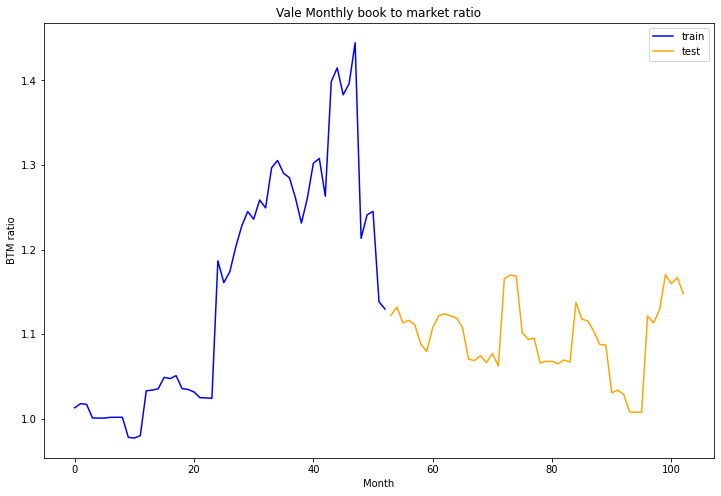

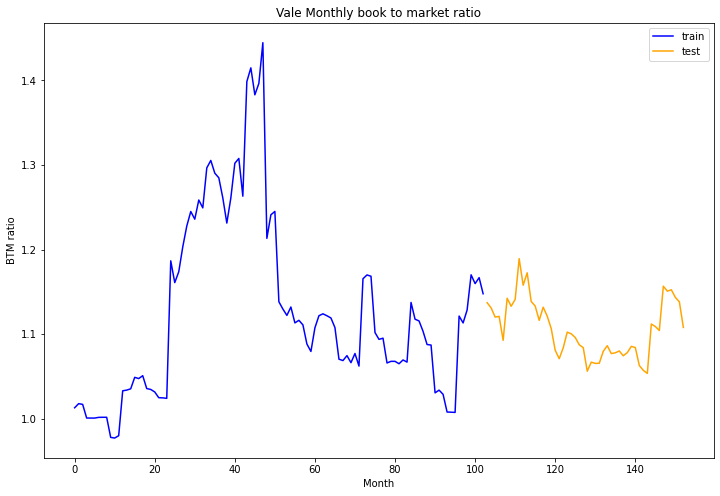

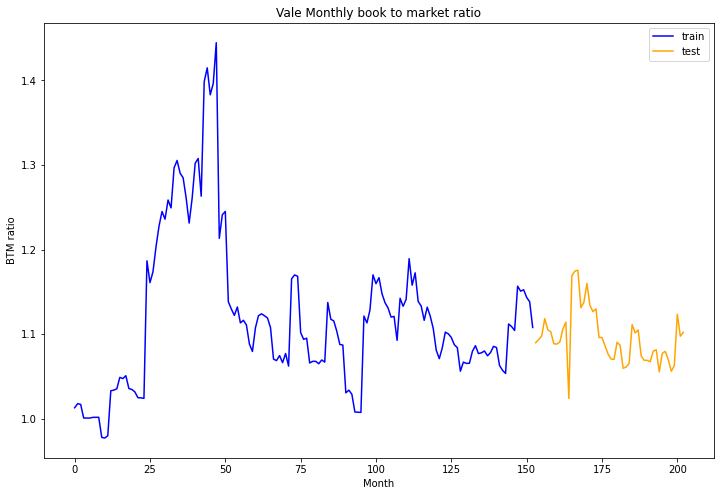

In [62]:
for train, val in splits.split(book_to_mkt_ratio):
    train_btm = book_to_mkt_ratio.loc[train]
    train_me = mcap.loc[train]
    train_mom = lreturn.loc[train]
    train_return = monthly_return.loc[train]
    
    val_btm = book_to_mkt_ratio.loc[val]
    val_me = mcap.loc[val]
    val_mom = lreturn.loc[val]
    
    test_return = monthly_return.loc[val]

    plt.figure(figsize=(12,8))
    plt.title("Vale Monthly book to market ratio")
    plt.ticklabel_format(style='plain')
    train_btm['VALE3'].plot(c='blue', label='train')
    val_btm['VALE3'].plot(c='orange', label='test')
    plt.xlabel('Month')
    plt.ylabel('BTM ratio')
    plt.legend()
    # plt.grid()
    plt.show()

In [5]:
list(train_me.columns)

['ABCB4',
 'ABRE11',
 'AEDU3',
 'AELP3',
 'AGEN11',
 'AGRO3',
 'ALLL3',
 'ALPA4',
 'ALSC3',
 'AMAR3',
 'AMBV3',
 'AMBV4',
 'AMIL3',
 'ARZZ3',
 'AUTM3',
 'BAZA3',
 'BBAS3',
 'BBDC3',
 'BBDC4',
 'BBRK3',
 'BEEF3',
 'BEMA3',
 'BHGR3',
 'BICB4',
 'BISA3',
 'BOBR4',
 'BPHA3',
 'BPNM4',
 'BRAP4',
 'BRFS3',
 'BRIN3',
 'BRKM5',
 'BRML3',
 'BRPR3',
 'BRSR6',
 'BRTO3',
 'BRTO4',
 'BTOW3',
 'BTTL4',
 'BVMF3',
 'CARD3',
 'CCIM3',
 'CCPR3',
 'CCRO3',
 'CESP6',
 'CGAS3',
 'CGAS5',
 'CIEL3',
 'CLSC6',
 'CMIG3',
 'CMIG4',
 'CNFB4',
 'COCE3',
 'COCE5',
 'CPFE3',
 'CPLE3',
 'CPLE6',
 'CRDE3',
 'CREM3',
 'CRUZ3',
 'CSAN3',
 'CSMG3',
 'CSNA3',
 'CTAX3',
 'CTAX4',
 'CTIP3',
 'CTNM4',
 'CYRE3',
 'CZLT11',
 'CZRS4',
 'DAGB11',
 'DASA3',
 'DAYC4',
 'DIRR3',
 'DROG3',
 'DTEX3',
 'ECOR3',
 'ELET3',
 'ELET6',
 'ELPL4',
 'EMBR3',
 'ENBR3',
 'EQTL3',
 'ESTC3',
 'ESTR4',
 'ETER3',
 'EUCA4',
 'EVEN3',
 'EZTC3',
 'FESA4',
 'FFTL4',
 'FHER3',
 'FIBR3',
 'FJTA4',
 'FLRY3',
 'FRAS4',
 'FRIO3',
 'FTRX4',
 'GETI3',
 'GETI

In [6]:
def create_characteristics(me_df, mom_df, btm_df, return_df):
    firm_characteristics = defaultdict(list)

    stocks_names = list(return_df.columns)

    time = return_df.shape[0] 
    number_of_stocks = len(stocks_names)
    r = np.empty(shape=(number_of_stocks, time))
    epsilon = 1e-10

    for i, name in enumerate(stocks_names):
        me = me_df.get(name)
        mom = mom_df.get(name)
        btm = btm_df.get(name)
        mr = return_df.get(name) 

        firm_characteristics[(i,'me')] = me.fillna(method='bfill')
        firm_characteristics[(i,'btm')] = btm.fillna(method='bfill')
        firm_characteristics[(i,'mom')]= mom.fillna(method='bfill')

        r[i] = mr.fillna(method='bfill')

    print("Created firm characteristics matrix")
    firm_characteristics = pd.DataFrame(firm_characteristics)
    #Normalize firm characteristics for each stock
    sum_df = firm_characteristics.T.loc[(slice(None), "me"), :].sum()
    firm_characteristics.T.loc[(slice(None), "me"), :] -= firm_characteristics.T.loc[(slice(None), "me"), :].mean()
    firm_characteristics.T.loc[(slice(None), "me"), :] /= (sum_df + epsilon)

    sum_df = firm_characteristics.T.loc[(slice(None), "btm"), :].sum()
    firm_characteristics.T.loc[(slice(None), "btm"), :] -= firm_characteristics.T.loc[(slice(None), "btm"), :].mean()
    firm_characteristics.T.loc[(slice(None), "btm"), :] /= (sum_df + epsilon)


    sum_df = firm_characteristics.T.loc[(slice(None), "mom"), :].sum()
    firm_characteristics.T.loc[(slice(None), "mom"), :] -= firm_characteristics.T.loc[(slice(None), "mom"), :].mean()
    firm_characteristics.T.loc[(slice(None), "mom"), :] /= (sum_df + epsilon)

    print("Normalized firm characteristics")
    return firm_characteristics, r, time, number_of_stocks

In [44]:
firm_characteristics, r, time, number_of_stocks = create_characteristics(train_me, train_mom, train_btm, train_return)

Created firm characteristics matrix
Normalized firm characteristics


In [45]:
# Creating a weight from a benchmark portifolio this one
# specific is related to return of each stock for simplicity
# w_benchmark = np.empty(shape=(number_of_stocks, time))
# epsilon=1e-5
# for t in range(time):
#     positive_returns = (r[:,t]-min(r[:,t]))+epsilon
#     w_benchmark[:,t] = positive_returns/sum(positive_returns)

w_benchmark = np.ones(shape=(number_of_stocks, time))
w_benchmark *= 1/number_of_stocks

In [46]:
def utility_function(risk_factor, portfolio_return):
    value = ((1 + portfolio_return)**(1-risk_factor))/(1-risk_factor)
    return value

In [47]:
def objective(theta): 
    w = np.empty(shape=(number_of_stocks, time))
    for i in range(number_of_stocks):
        w[i] = w_benchmark[i].copy() + (1/number_of_stocks)*theta.dot(firm_characteristics[i].copy().T)
    return -sum(sum(utility_function(5, w[:,:-1]*r[:,1:])))/time

In [48]:
def constraint(theta):
    w_sol = np.empty(shape=(number_of_stocks, time))
    for i in range(number_of_stocks):
        firm_df = firm_characteristics[i].copy()
        firms_coeff = sol_theta.dot(firm_df.T)
        w_sol[i] = w_benchmark[i] + (1/number_of_stocks)*firms_coeff
    mean_w = np.sum(w_sol, axis=1)/time
    return mean_w

cons = [{"type" : "ineq", "fun" : constraint}]

In [49]:
np.random.seed(123)
theta0 = np.random.rand(1, 3)
theta0

array([[0.69646919, 0.28613933, 0.22685145]])

In [50]:
from scipy.optimize import minimize, differential_evolution

In [51]:
opt_iter = 1
mean_obj_r = []
mean_r = []
def callback_steps(thetaI):
    global opt_iter
    print(f"i:{opt_iter}, theta i: {thetaI}, f(theta):{objective(thetaI)}")
    mean_obj_r.append(-objective(thetaI))
    
    w_iter = np.empty(shape=(number_of_stocks, time))
    for i in range(number_of_stocks):
        w_iter[i] = w_benchmark[i] + (1/number_of_stocks)*thetaI.dot(firm_characteristics[i].copy().T)
    mean_r.append(sum(sum(w_iter*r))/time)
    
    opt_iter += 1

In [52]:
# sol = minimize(objective, theta0, callback=callback_steps, method='COBYLA', constraints=cons)
sol = minimize(objective, theta0, callback=callback_steps, method='CG')
sol

i:1, theta i: [0.69412759 0.26036287 0.1046067 ], f(theta):62.506089522435346
i:2, theta i: [0.68704864 0.18215345 0.03677422], f(theta):62.488603664061564
i:3, theta i: [ 0.515784   -1.65819902  0.2398007 ], f(theta):62.347851612870805
i:4, theta i: [ 0.2562542  -4.39814072  0.15174749], f(theta):62.194907304472224
i:5, theta i: [ 0.25210131 -4.40037014  0.06498297], f(theta):62.17735320098645
i:6, theta i: [ 0.15598762 -4.4527507   0.04533013], f(theta):62.175864053139044
i:7, theta i: [-2.00358085 -5.62770066  0.15033682], f(theta):62.14622286311549
i:8, theta i: [-18.03809905 -14.33717625   0.12102287], f(theta):62.04841377728402
i:9, theta i: [-18.03887908 -14.33471306   0.06903766], f(theta):62.04172268420965
i:10, theta i: [-18.04037847 -14.32996985   0.0639538 ], f(theta):62.041660973746204
i:11, theta i: [-20.31124385  -7.14728598   0.08274216], f(theta):61.97262141758819
i:12, theta i: [-20.3540108   -7.01321779   0.06245651], f(theta):61.971598954027286
i:13, theta i: [-20.4

     fun: 61.965288671436646
     jac: array([-1.43051147e-06, -3.33786011e-06, -8.58306885e-06])
 message: 'Optimization terminated successfully.'
    nfev: 400
     nit: 33
    njev: 100
  status: 0
 success: True
       x: array([-24.74403462,  -6.20158451,   0.06740677])

In [53]:
sol_theta = sol.x
w_sol = np.empty(shape=(number_of_stocks, time))
for i in range(number_of_stocks):
    firm_df = firm_characteristics[i].copy()
    firms_coeff = sol_theta.dot(firm_df.T)
    w_sol[i] = w_benchmark[i] + (1/number_of_stocks)*firms_coeff

In [54]:
np.sum(w_sol, axis=1)/time

array([ 0.0042696 ,  0.00430563,  0.00421052,  0.00446594,  0.00431262,
        0.00450228,  0.00444514,  0.0044569 ,  0.00435485,  0.00422745,
        0.00285353,  0.00285446,  0.00376939,  0.00426633,  0.00426393,
        0.00447931,  0.00346405,  0.00279713,  0.00280144,  0.00428301,
        0.00430967,  0.00440288,  0.00437911,  0.0040842 ,  0.00412977,
        0.00445526,  0.00431801,  0.00420679,  0.00430268,  0.00440185,
        0.0044047 ,  0.00428924,  0.00426681,  0.00427129,  0.0044401 ,
        0.00405503,  0.00406988,  0.00345579,  0.00452173,  0.00135464,
        0.00438759,  0.00428593,  0.00436169,  0.00425568,  0.00421125,
        0.00434823,  0.00436082,  0.0016798 ,  0.00443378,  0.00387064,
        0.00387288,  0.00446474,  0.00442923,  0.00442894,  0.00360819,
        0.00411624,  0.00411635,  0.00438689,  0.00443477,  0.00400582,
        0.00404376,  0.00414972,  0.00396068,  0.00445373,  0.00444393,
        0.0041767 ,  0.00441012,  0.00442701,  0.00394052,  0.00

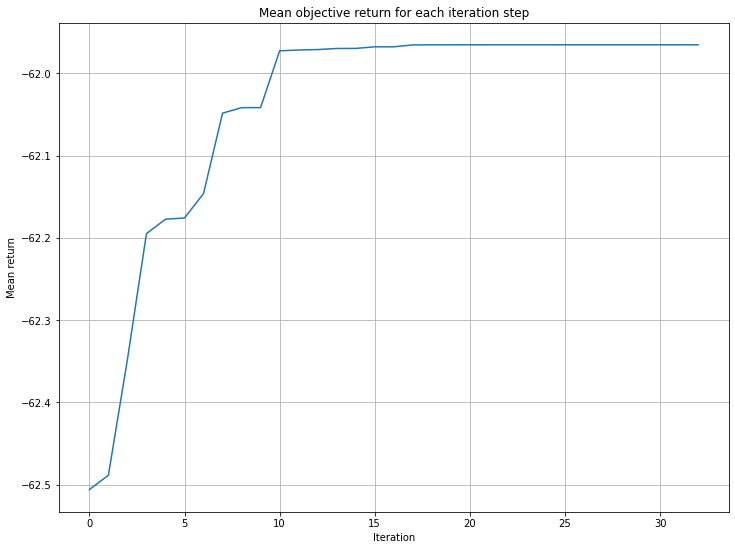

In [55]:
x = range(len(mean_obj_r))
plt.figure(figsize=(12,9))
plt.title("Mean objective return for each iteration step")
plt.plot(x, mean_obj_r)
plt.xlabel('Iteration')
plt.ylabel('Mean return')
plt.ticklabel_format(style='plain')
plt.grid()
plt.show()

In [56]:
benchmark_mean_return = sum(sum(w_benchmark*r)/time)

# Equally diveded weights for each stock
uniform_weighted_stocks = np.ones_like(w_benchmark)*(1/number_of_stocks)
uniform_weighted_return = sum(sum(uniform_weighted_stocks*r))

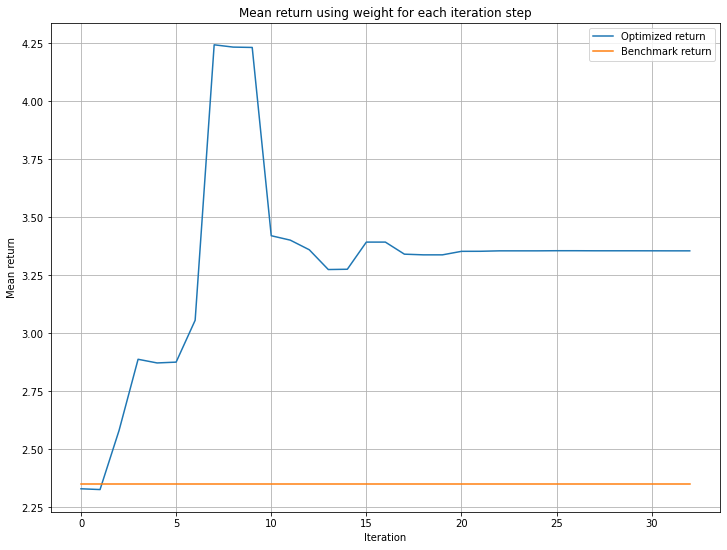

In [57]:
x = range(len(mean_r))
plt.figure(figsize=(12,9))
plt.title("Mean return using weight for each iteration step")
plt.plot(x, mean_r, label='Optimized return')
plt.plot(x, [benchmark_mean_return]*len(x), label='Benchmark return')
# plt.plot(x, [uniform_weighted_return]*len(x), label='Uniform weight return')
plt.xlabel('Iteration')
plt.ylabel('Mean return')
plt.legend()
plt.grid()
plt.show()

### Testing

In [141]:
sol_theta = sol.x
firm_characteristics_val, r_val, time_val, number_of_stocks = create_characteristics(val_me, val_mom, val_btm, test_return)
firm_characteristics_val.fillna(method='ffill', inplace=True)

#### CREATE BENCHMARK FOR TESTING
w_benchmark_val = np.empty(shape=(number_of_stocks, time_val))
epsilon=1e-5
for t in range(time_val):
    positive_returns = (r_val[:,t]-min(r_val[:,t]))+epsilon
    w_benchmark_val[:,t] = positive_returns/sum(positive_returns)
    
w_val = np.empty(shape=(number_of_stocks, time_val))

for i in range(number_of_stocks):
    firm_df = firm_characteristics_val[i].copy()
    firms_coeff = sol_theta.dot(firm_df.T)
    w_val[i] = w_benchmark_val[i] + (1/number_of_stocks)*firms_coeff

Created firm characteristics matrix
Normalized firm characteristics


In [142]:
benchmark_mean_return = sum(sum(w_benchmark_val*r_val))
benchmark_mean_return

381.18393749693354

In [143]:
mean_return = sum(sum(w_val*r_val))
mean_return

386.4309169605893

### Testing and optimizing

In [92]:
sol_theta = sol.x
w_sol = np.empty(shape=(number_of_stocks, time))
for i in range(number_of_stocks):
    firm_df = firm_characteristics[i].copy()
    firms_coeff = sol_theta.dot(firm_df.T)
    w_sol[i] = w_benchmark[i] + (1/number_of_stocks)*firms_coeff

In [94]:
sum(np.sum(w_sol, axis=1)/time)

0.9999999999996554

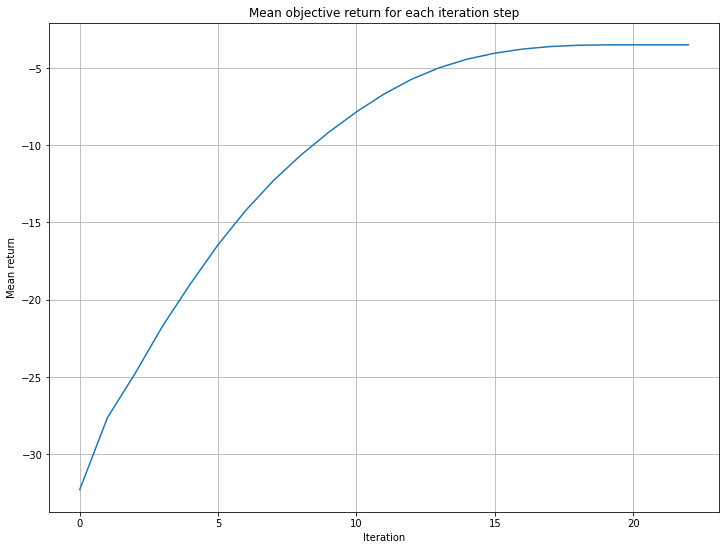

In [95]:
x = range(len(mean_obj_r))
plt.figure(figsize=(12,9))
plt.title("Mean objective return for each iteration step")
plt.plot(x, mean_obj_r)
plt.xlabel('Iteration')
plt.ylabel('Mean return')
plt.ticklabel_format(style='plain')
plt.grid()
plt.show()

In [97]:
benchmark_mean_return = sum(sum(w_benchmark*r))

# Equally diveded weights for each stock
uniform_weighted_stocks = np.ones_like(w_benchmark)*(1/number_of_stocks)
uniform_weighted_return = sum(sum(uniform_weighted_stocks*r))

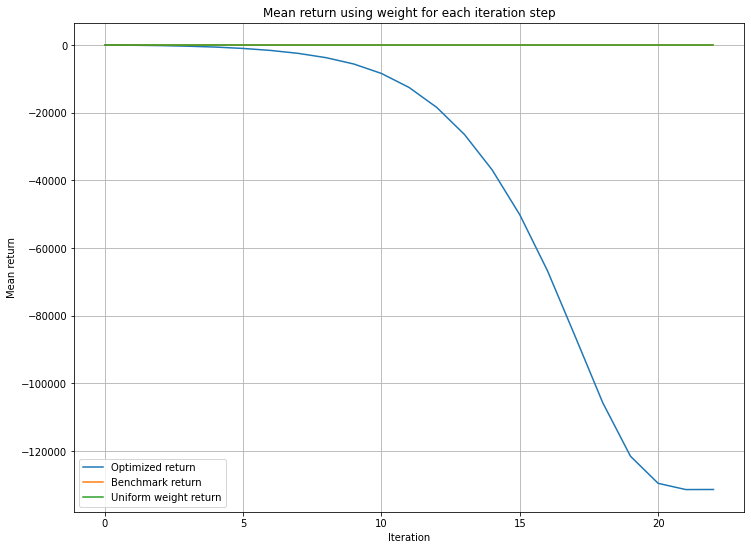

In [98]:
x = range(len(mean_r))
plt.figure(figsize=(12,9))
plt.title("Mean return using weight for each iteration step")
plt.plot(x, mean_r, label='Optimized return')
plt.plot(x, [benchmark_mean_return]*len(x), label='Benchmark return')
plt.plot(x, [uniform_weighted_return]*len(x), label='Uniform weight return')
plt.xlabel('Iteration')
plt.ylabel('Mean return')
plt.legend()
plt.grid()
plt.show()

In [144]:
# For each tuple try previous theta and try to optmize
mean_obj_r_tuple = []
mean_r_tuple = []
bench_tuple = []
eq_weighted_tuple = []
return_tuple = []

for i in range(0, test_return.shape[0], 2):
    firm_characteristics_val, r_val, time_val, number_of_stocks = create_characteristics(val_me.iloc[i:i+2], val_mom.iloc[i:i+2], val_btm.iloc[i:i+2], test_return.iloc[i:i+2])
    firm_characteristics_val.fillna(method='ffill', inplace=True)
    
    sol_theta = sol.x
    theta0 = sol_theta
    firm_characteristics = firm_characteristics_val
    r = r_val
    time = time_val

    w_benchmark = np.empty(shape=(number_of_stocks, time))
    epsilon=1e-5
    for t in range(time):
        positive_returns = (r[:,t]-min(r[:,t]))+epsilon
        w_benchmark[:,t] = positive_returns/sum(positive_returns)
    
    opt_iter = 1
    mean_obj_r = []
    mean_r = []
    sol = minimize(objective, theta0, callback=callback_steps, method='BFGS')
    mean_obj_r_tuple.append(mean_obj_r)
    mean_r_tuple.append(mean_r)
    
    
    benchmark_mean_return = sum(sum(w_benchmark*r))
    bench_tuple.append(benchmark_mean_return)
    
    # Equally diveded weights for each stock
    uniform_weighted_stocks = np.ones_like(w_benchmark)*(1/number_of_stocks)
    uniform_weighted_return = sum(sum(uniform_weighted_stocks*r))
    eq_weighted_tuple.append(uniform_weighted_return)
    
    sol_theta = sol.x
    w_sol = np.empty(shape=(number_of_stocks, time))
    for i in range(number_of_stocks):
        firm_df = firm_characteristics[i].copy()
        firms_coeff = sol_theta.dot(firm_df.T)
        w_sol[i] = w_benchmark[i] + (1/number_of_stocks)*firms_coeff
    
    return_tuple.append(sum(sum(w_sol*r)))
    

Created firm characteristics matrix
Normalized firm characteristics
i:1, theta i: [-83.81633265   3.08145557  -7.6132865 ], f(theta):32.29670300267634
i:2, theta i: [-83.1227851    3.15723658 -27.93866206], f(theta):27.644127591297295
i:3, theta i: [-82.38243268   3.2383676  -49.63512763], f(theta):24.780533304768994
i:4, theta i: [-81.08058064   3.38122949 -87.79842664], f(theta):21.689592483010074
i:5, theta i: [ -79.18195282    3.58971725 -143.47223628], f(theta):18.97704619254287
i:6, theta i: [ -76.23670215    3.9132508  -229.85414032], f(theta):16.442163771758835
i:7, theta i: [ -71.8994728     4.38981595 -357.07825958], f(theta):14.220080130353688
i:8, theta i: [ -65.55870949    5.08665809 -543.08546154], f(theta):12.293418279627058
i:9, theta i: [ -56.33947512    6.09996936 -813.54313532], f(theta):10.62943994571219
i:10, theta i: [  -42.72240296     7.5967721  -1213.02425001], f(theta):9.1606090872453
i:11, theta i: [  -22.34463042     9.83680986 -1810.84831788], f(theta):7.84

i:36, theta i: [   901.91433317   1142.88473035 -23894.58491564], f(theta):77.84674601938757
i:37, theta i: [   900.36125993   1150.33787777 -23890.36869333], f(theta):77.84142960260355
i:38, theta i: [   898.08289574   1162.71550347 -23883.15048577], f(theta):77.83204275162377
i:39, theta i: [   894.81473744   1181.83226163 -23871.48682104], f(theta):77.81606365249662
i:40, theta i: [   890.57730977   1210.10846789 -23853.28868882], f(theta):77.78951530280197
i:41, theta i: [   885.84352539   1248.14774818 -23827.05549949], f(theta):77.74448073386017
i:42, theta i: [   880.95463698   1296.76117876 -23790.52621529], f(theta):77.665121707788
i:43, theta i: [   875.6953398    1359.13140972 -23738.40077062], f(theta):77.52116232831646
i:44, theta i: [   869.63168102   1444.2410195  -23658.78807264], f(theta):77.25709245669819
i:45, theta i: [   862.09508059   1565.77717287 -23530.59252929], f(theta):76.77387780948155
i:46, theta i: [   852.21252807   1743.31949553 -23316.94906067], f(thet

i:12, theta i: [   415.63278825 -19078.40325463  -5831.33991312], f(theta):92.23497384588298
i:13, theta i: [   416.8233729  -19077.79380582  -5833.08514141], f(theta):92.2276987840848
i:14, theta i: [   418.28699259 -19077.11312136  -5835.34842447], f(theta):92.2139440980481
i:15, theta i: [   420.25209312 -19076.31170522  -5838.58048596], f(theta):92.18785432984974
i:16, theta i: [   423.10674357 -19075.33136587  -5843.59159551], f(theta):92.13897665440548
i:17, theta i: [   427.35306425 -19074.21349489  -5851.63056811], f(theta):92.04873596692963
i:18, theta i: [   433.80763538 -19073.14648296  -5864.93647197], f(theta):91.88677760066643
i:19, theta i: [   443.5362744  -19072.79815436  -5887.15690053], f(theta):91.60714743753968
i:20, theta i: [   457.54394566 -19074.9408472   -5923.69454757], f(theta):91.1438536364093
i:21, theta i: [   475.77732273 -19083.34737934  -5980.90765351], f(theta):90.3945505905183
i:22, theta i: [   496.01480087 -19104.32290905  -6064.42019683], f(theta)

i:15, theta i: [  1749.33987007 -16179.21608273  -6461.8220144 ], f(theta):45470.86529076499
i:16, theta i: [  1766.02909327 -16153.22236225  -6453.03601861], f(theta):44311.499892467364
i:17, theta i: [  1773.80182089 -16112.77373213  -6444.07966419], f(theta):42233.82258703611
i:18, theta i: [  1772.15687423 -16107.46372535  -6432.01039945], f(theta):38579.782498575245
i:19, theta i: [  1728.6328171  -16101.79836763  -6421.90727732], f(theta):32262.01765983305
i:20, theta i: [  1603.11997739 -16176.09054681  -6412.12245211], f(theta):22286.563614723756
i:21, theta i: [  1389.89077113 -16322.6715644   -6405.64802344], f(theta):13319.263056051434
i:22, theta i: [  1159.71548057 -16487.35005008  -6401.2881517 ], f(theta):8268.94008059751
i:23, theta i: [   886.88620822 -16684.89014829  -6397.04123989], f(theta):5074.0834684274605
i:24, theta i: [   582.5680775  -16906.38827833  -6392.71119564], f(theta):3209.6401430726196
i:25, theta i: [   265.2509127  -17138.30316206  -6388.37511771],

i:12, theta i: [6145102.87778176 6381609.94897161 1954842.86706127], f(theta):1.0527822198564358
i:13, theta i: [6145017.11117556 6381602.13717659 1955147.00697775], f(theta):0.8330125684718562
i:14, theta i: [6144921.91016542 6381593.46610038 1955484.60265059], f(theta):0.7029254333479865
i:15, theta i: [6144809.84646767 6381583.25914208 1955881.99564586], f(theta):0.6215686229802594
i:16, theta i: [6144685.91418689 6381571.97116514 1956321.47623819], f(theta):0.5739737705470564
i:17, theta i: [6144542.16422823 6381558.87816254 1956831.2329766 ], f(theta):0.5446947268173705
i:18, theta i: [6144376.42562696 6381543.78239497 1957418.96441654], f(theta):0.5269911746288333
i:19, theta i: [6144201.58891641 6381527.85795545 1958038.95897467], f(theta):0.5170340849383923
i:20, theta i: [6143994.28643762 6381508.97647581 1958774.08152814], f(theta):0.5106743337715296
Created firm characteristics matrix
Normalized firm characteristics
i:1, theta i: [6143770.28643845 6381342.30980976 1960114.08

In [146]:
x = range(len(return_tuple))

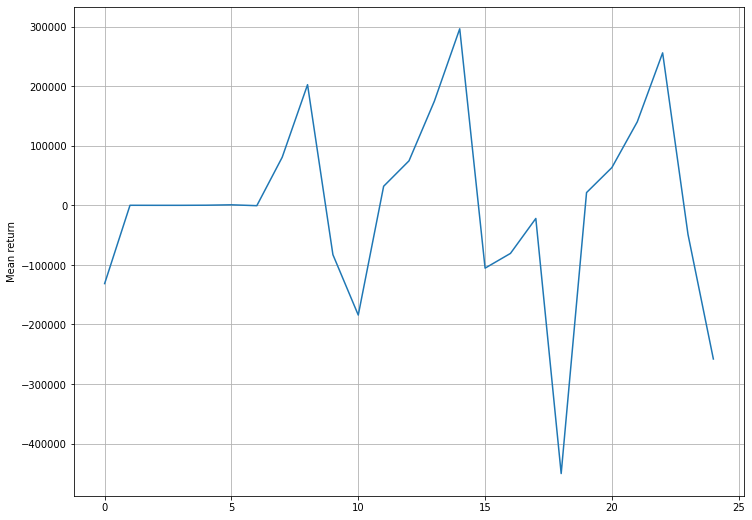

In [149]:
x = range(len(return_tuple))
plt.figure(figsize=(12,9))
plt.plot(x,return_tuple)
# plt.xlabel('Iteration')
plt.ylabel('Mean return')
# plt.legend()
plt.grid()
plt.show()

In [151]:
sum(return_tuple)/len(return_tuple)

-814.2736236383219

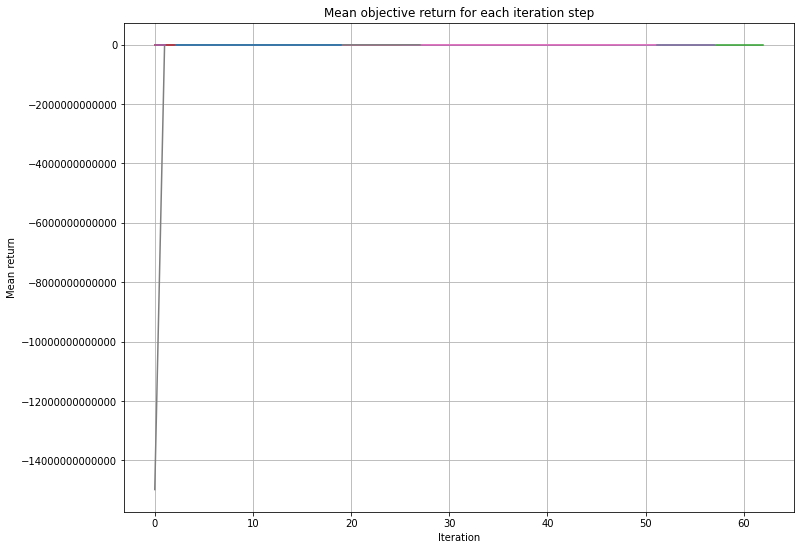

In [157]:
plt.figure(figsize=(12,9))
plt.title("Mean objective return for each iteration step")
for mean_obj_r in mean_obj_r_tuple:
    x = range(len(mean_obj_r))
    plt.plot(x, mean_obj_r)

plt.xlabel('Iteration')
plt.ylabel('Mean return')
plt.ticklabel_format(style='plain')
plt.grid()
plt.show()

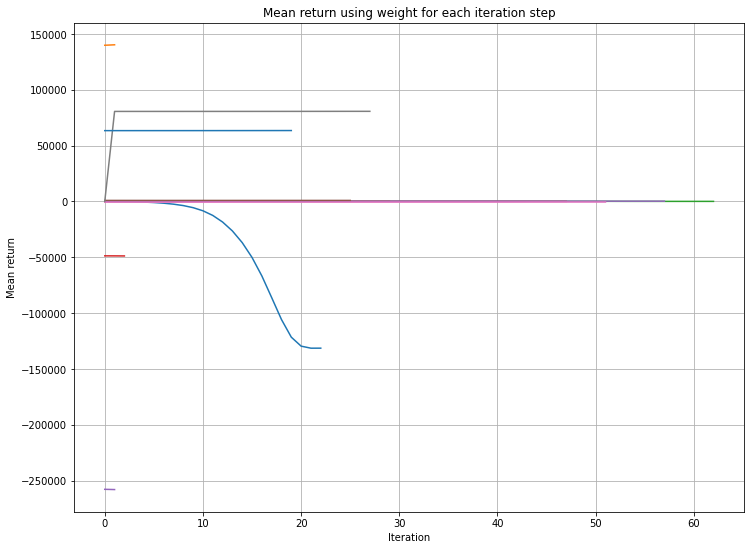

In [158]:
plt.figure(figsize=(12,9))
plt.title("Mean return using weight for each iteration step")
for mean_r in mean_r_tuple:
    x = range(len(mean_r))
    plt.plot(x, mean_r)

plt.xlabel('Iteration')
plt.ylabel('Mean return')
plt.ticklabel_format(style='plain')
plt.grid()
plt.show()

## Training with k-fold (k=10)

In [2]:
lreturn = pd.read_csv('../data/monthly_lagged_return.csv')
mcap = pd.read_csv('../data/monthly_market_cap.csv')
book_to_mkt_ratio = pd.read_csv('../data/monthly_book_to_mkt_ratio.csv')
monthly_return = pd.read_csv('../data/monthly_return.csv')
lreturn.fillna(method='bfill', inplace=True)
lreturn.fillna(method='ffill', inplace=True)
mcap.fillna(method='bfill', inplace=True)
mcap.fillna(method='ffill', inplace=True)
book_to_mkt_ratio.fillna(method='bfill', inplace=True)
book_to_mkt_ratio.fillna(method='ffill', inplace=True)
monthly_return.fillna(method='bfill', inplace=True)
monthly_return.fillna(method='ffill', inplace=True)

In [3]:
from sklearn.model_selection import TimeSeriesSplit
num_folds = 10
splits = TimeSeriesSplit(n_splits=num_folds)

In [4]:
def create_characteristics(me_df, mom_df, btm_df, return_df, stocks_names):
    
    firm_characteristics = defaultdict(list)
    time = return_df.shape[0] 
    number_of_stocks = len(stocks_names)
    r = np.empty(shape=(number_of_stocks, time))
    epsilon = 1e-10

    for i, name in enumerate(stocks_names):
        me = me_df.get(name)
        mom = mom_df.get(name)
        btm = btm_df.get(name)
        mr = return_df.get(name) 

        firm_characteristics[(i,'me')] = me.fillna(method='bfill')
        firm_characteristics[(i,'btm')] = btm.fillna(method='bfill')
        firm_characteristics[(i,'mom')]= mom.fillna(method='bfill')

        r[i] = mr.fillna(method='bfill')

    print("Created firm characteristics matrix")
    firm_characteristics = pd.DataFrame(firm_characteristics)
    #Normalize firm characteristics for each stock
    sum_df = firm_characteristics.T.loc[(slice(None), "me"), :].sum()
    firm_characteristics.T.loc[(slice(None), "me"), :] -= firm_characteristics.T.loc[(slice(None), "me"), :].mean()
    firm_characteristics.T.loc[(slice(None), "me"), :] /= (sum_df + epsilon)

    sum_df = firm_characteristics.T.loc[(slice(None), "btm"), :].sum()
    firm_characteristics.T.loc[(slice(None), "btm"), :] -= firm_characteristics.T.loc[(slice(None), "btm"), :].mean()
    firm_characteristics.T.loc[(slice(None), "btm"), :] /= (sum_df + epsilon)


    sum_df = firm_characteristics.T.loc[(slice(None), "mom"), :].sum()
    firm_characteristics.T.loc[(slice(None), "mom"), :] -= firm_characteristics.T.loc[(slice(None), "mom"), :].mean()
    firm_characteristics.T.loc[(slice(None), "mom"), :] /= (sum_df + epsilon)

    print("Normalized firm characteristics")
    return firm_characteristics, r, time, number_of_stocks

In [5]:
def utility_function(risk_factor, portfolio_return):
    value = ((1 + portfolio_return)**(1-risk_factor))/(1-risk_factor)
    return value

In [6]:
def optimizing_step(firm_characteristics, r, time, number_of_stocks, theta0, w_benchmark):

    def objective(theta): 
        w = np.empty(shape=(number_of_stocks, time))
        for i in range(number_of_stocks):
            w[i] = w_benchmark[i].copy() + (1/number_of_stocks)*theta.dot(firm_characteristics[i].copy().T)
        return -sum(sum(utility_function(5, w[:,:-1]*r[:,1:])))/time
    
    opt_iter = 1
    mean_obj_r = []
    mean_r = []
    
    def callback_steps(thetaI):
        global opt_iter
        print(f"i:{opt_iter}, theta i: {thetaI}, f(theta):{objective(thetaI)}")
        mean_obj_r.append(-objective(thetaI))

        w_iter = np.empty(shape=(number_of_stocks, time))
        for i in range(number_of_stocks):
            w_iter[i] = w_benchmark[i] + (1/number_of_stocks)*thetaI.dot(firm_characteristics[i].copy().T)
        mean_r.append(sum(sum(w_iter*r))/time)

        opt_iter += 1
    
    sol = minimize(objective, theta0, callback=callback_steps, method='BFGS')
    return sol, mean_obj_r, mean_r

In [65]:
# %%timeit
start = tm.time()
mean_obj_r_fold = []
mean_r_fold = []
benchmark_r_fold = []
theta_fold = []

test_r_fold = []
benchmark_test_r_fold =[]

benchmark_weights_fold = []

stocks_names = list(monthly_return.columns)

w_test_results = []
np.random.seed(123)
for train, test in splits.split(book_to_mkt_ratio):    
    theta0 = np.random.rand(1, 3)
    
    train_btm = book_to_mkt_ratio.loc[train]
    train_me = mcap.loc[train]
    train_mom = lreturn.loc[train]
    train_return = monthly_return.loc[train]
    
    test_btm = book_to_mkt_ratio.loc[test]
    test_me = mcap.loc[test]
    test_mom = lreturn.loc[test]
    
    test_return = monthly_return.loc[test]
    
    #### TRAINING CHARACTERISTICS
    firm_characteristics, r, time, number_of_stocks = create_characteristics(train_me, train_mom, train_btm, train_return, stocks_names)
    
    # Creating a weight from a benchmark portifolio using uniform weighted    
    w_benchmark = np.ones(shape=(number_of_stocks, time))
    w_benchmark *= 1/number_of_stocks
    
    benchmark_weights_fold.append(w_benchmark)
    
    ### CREATING RETURNS TO COMPARE
    benchmark_mean_return = sum(sum(w_benchmark*r))/time
    benchmark_r_fold.append(benchmark_mean_return)
    
    opt_iter = 1
    sol, mean_obj_r, mean_r = optimizing_step(firm_characteristics, r, time, number_of_stocks, theta0, w_benchmark)
    sol_theta = sol.x
    
    ### SAVING PARAMETERS TO LOOKUP AFTER
    mean_r_fold.append(mean_r)
    mean_obj_r_fold.append(mean_obj_r)
    theta_fold.append(sol_theta)
    
    #### TESTING CHARACTERISTICS
    firm_characteristics_test, r_test, time_test, number_of_stocks = create_characteristics(test_me, test_mom, test_btm, test_return, stocks_names)
    firm_characteristics_test.fillna(method='ffill', inplace=True)

    #### CREATE BENCHMARK FOR TESTING
    w_benchmark_test = np.ones(shape=(number_of_stocks, time_test))
    w_benchmark_test *= 1/number_of_stocks

    benchmark_test_r = sum(sum(w_benchmark_test*r_test))/time_test
    benchmark_test_r_fold.append(benchmark_test_r)
    
    
    ### CREATE TEST WEIGHT AND FIND ITS RETURN
    w_test = np.empty(shape=(number_of_stocks, time_test))
    for i in range(number_of_stocks):
        firm_df = firm_characteristics_test[i].copy()
        firms_coeff = sol_theta.dot(firm_df.T)
        w_test[i] = w_benchmark_test[i] + (1/number_of_stocks)*firms_coeff
    
    w_test_results.append(w_test)
    test_r = sum(sum(w_test*r_test))/time_test
    test_r_fold.append(test_r)


end = tm.time()

Created firm characteristics matrix
Normalized firm characteristics
i:1, theta i: [ 0.69033811  0.23553695 -0.17114022], f(theta):61.19658651882002
i:2, theta i: [ 0.66700189  0.04302247 -0.16304128], f(theta):61.161304550873645
i:3, theta i: [ 0.6097152  -0.37173921 -0.14868662], f(theta):61.09891134025038
i:4, theta i: [ 0.46004647 -1.33227921 -0.12365424], f(theta):61.00473873137434
i:5, theta i: [ 0.25866826 -2.47499163 -0.10931809], f(theta):60.94640425867629
i:6, theta i: [ 0.04768979 -3.54073526 -0.11070944], f(theta):60.91942427424157
i:7, theta i: [-0.1655435  -4.49970817 -0.11945712], f(theta):60.907780511349145
i:8, theta i: [-0.34162651 -5.18458326 -0.12699941], f(theta):60.904012967400455
i:9, theta i: [-0.4728235  -5.59457262 -0.13050739], f(theta):60.90270536887287
i:10, theta i: [-0.61815777 -5.93282399 -0.13189911], f(theta):60.90151448550031
i:11, theta i: [-0.8496678  -6.32605334 -0.13178068], f(theta):60.89948552917247
i:12, theta i: [-1.22497492 -6.7940794  -0.1298

i:17, theta i: [-13.05548785 -12.758935    -0.26201569], f(theta):62.21379873120743
i:18, theta i: [-18.03859189 -11.77661524  -0.2593056 ], f(theta):62.17293134519448
i:19, theta i: [-24.36357269  -7.5433855   -0.25806897], f(theta):62.11330103540292
i:20, theta i: [-25.3428092   -5.63507597  -0.25880191], f(theta):62.103326678142686
i:21, theta i: [-24.30858944  -5.27234696  -0.25978249], f(theta):62.101982811417216
i:22, theta i: [-22.96803536  -5.35770418  -0.26064371], f(theta):62.101517127734056
i:23, theta i: [-23.07685745  -5.33209693  -0.26058767], f(theta):62.10151177757179
i:24, theta i: [-23.07466515  -5.33350569  -0.26058824], f(theta):62.10151177195666
i:25, theta i: [-23.07460001  -5.33351207  -0.26058828], f(theta):62.10151177195662
i:26, theta i: [-23.07518128  -5.33290609  -0.26058937], f(theta):62.10151174771043
i:27, theta i: [-23.07834938  -5.32966184  -0.2606007 ], f(theta):62.10151153376536
i:28, theta i: [-23.08297023  -5.32529025  -0.26062399], f(theta):62.1015

i:25, theta i: [-25.44949919  -5.73926115  -0.30725063], f(theta):62.07509747703059
i:26, theta i: [-25.44974294  -5.73929197  -0.30747794], f(theta):62.07509745300004
Created firm characteristics matrix
Normalized firm characteristics
Created firm characteristics matrix
Normalized firm characteristics
i:1, theta i: [0.53155302 0.53181297 0.62501971], f(theta):72.14041195433926
i:2, theta i: [0.58626927 0.37481639 0.62588001], f(theta):72.11067134259268
i:3, theta i: [ 0.74341753 -0.02677888  0.62648117], f(theta):72.0646267661514
i:4, theta i: [ 1.02477896 -0.63033717  0.62649334], f(theta):72.02270133095239
i:5, theta i: [ 1.28188969 -1.04978373  0.62616813], f(theta):72.00656567436293
i:6, theta i: [ 1.51893676 -1.31551536  0.62594478], f(theta):71.99933750982073
i:7, theta i: [ 1.87425581 -1.58212623  0.62575183], f(theta):71.99050997260889
i:8, theta i: [ 2.47635876 -1.88514113  0.62554078], f(theta):71.9756531465861
i:9, theta i: [ 3.49516789 -2.21813153  0.6252637 ], f(theta):71

i:34, theta i: [-18.71110997  -6.26209728   0.07463074], f(theta):62.57197139667048
i:35, theta i: [-18.64356045  -6.22748926   0.07365013], f(theta):62.57196482127556
i:36, theta i: [-18.63210856  -6.22032505   0.07369054], f(theta):62.57196467299373
i:37, theta i: [-18.63254859  -6.21887193   0.07370485], f(theta):62.57196467296801
Created firm characteristics matrix
Normalized firm characteristics
Created firm characteristics matrix
Normalized firm characteristics
i:1, theta i: [0.22826584 0.29370274 0.62580389], f(theta):69.44588873438661
i:2, theta i: [0.26971901 0.192919   0.62594345], f(theta):69.4345290761685
i:3, theta i: [ 0.36667895 -0.01919329  0.62598711], f(theta):69.41394409068435
i:4, theta i: [ 0.60748195 -0.4871451   0.62605756], f(theta):69.38166863923878
i:5, theta i: [ 0.98325602 -1.12102315  0.62613465], f(theta):69.35923520680434
i:6, theta i: [ 1.23410592 -1.45653217  0.6261578 ], f(theta):69.35323904175364
i:7, theta i: [ 1.49921863 -1.72020996  0.62615498], f(

In [96]:
print(f"Duration: {end-start}s")

Duration: 393.7141110897064s


In [97]:
colors ={
    0:'black',
    1:'blue',
    2:'coral',
    3:'magenta',
    4:'grey',
    5:'violet',
    6:'brown',
    7:'red',
    8:'salmon',
    9:'green'
}

Single fold return optmization

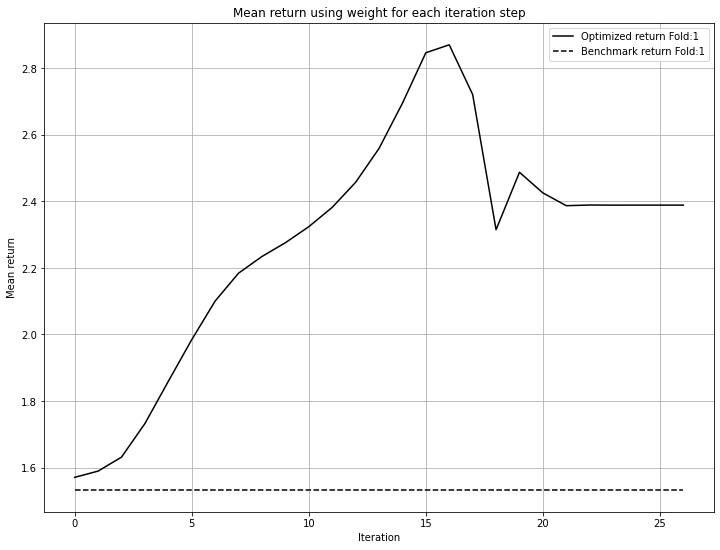

In [98]:
plt.figure(figsize=(12,9))
plt.title("Mean return using weight for each iteration step")
for fold, mean_r in enumerate(mean_r_fold):
    x = range(len(mean_r))
    plt.plot(x, mean_r, label=f'Optimized return Fold:{fold+1}', c=colors[fold])
    plt.plot(x, [benchmark_r_fold[fold]]*len(mean_r), label=f'Benchmark return Fold:{fold+1}', c=colors[fold], linestyle='dashed')
#     plt.plot(x, [eq_weighetd_r_fold[fold]]*len(mean_r), label=f'Equally weighted return Fold:{fold+1}', c=colors[fold], marker='.')
    plt.xlabel('Iteration')
    plt.ylabel('Mean return')
    plt.legend()
    plt.grid()
    break
plt.show()

In [137]:
min_i = 0
lowest = np.Inf
for i in range(10):
    w_describe = pd.DataFrame(w_test_results[i].T).describe()
    negative_sum = sum(w_describe.loc['min'][w_describe.loc['min'] < 0])
    if negative_sum < lowest:
        lowest=negative_sum
        min_i = i
    print(f"i:{i}, negative_sum:{negative_sum}")

i:0, negative_sum:-0.015325534589280373
i:1, negative_sum:-0.017364886613072884
i:2, negative_sum:-0.03803727679121233
i:3, negative_sum:-0.031537029176904076
i:4, negative_sum:-0.02722462907156179
i:5, negative_sum:-0.4812819193987488
i:6, negative_sum:-0.0008008588643002674
i:7, negative_sum:-0.004104487088404267
i:8, negative_sum:-0.013155837096693943
i:9, negative_sum:0


In [139]:
w_describe = pd.DataFrame(w_test_results[min_i].T).describe()
w_describe

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,...,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000
mean,0.004376,0.005195,0.004775,0.004863,0.005457,0.003988,0.003147,0.004374,0.003869,0.004721,...,0.004250,0.004517,-0.000882,-0.000940,0.004070,0.002867,0.002852,0.005053,0.004187,0.004368
std,0.000015,0.003367,0.001829,0.001687,0.004452,0.002195,0.004895,0.000282,0.002339,0.001561,...,0.001960,0.000519,0.000703,0.000567,0.001301,0.000310,0.000392,0.002601,0.000037,0.000324
min,0.004346,0.004123,0.004199,0.004356,0.004036,-0.004803,-0.016467,0.003249,-0.005497,0.004231,...,0.003538,0.004358,-0.001868,-0.001851,-0.001141,0.001943,0.001507,0.004224,0.004111,0.003070
25%,0.004369,0.004404,0.004325,0.004432,0.004418,0.004460,0.004264,0.004427,0.004367,0.004335,...,0.003730,0.004387,-0.001437,-0.001438,0.004343,0.002740,0.002779,0.004445,0.004162,0.004434
50%,0.004376,0.004428,0.004361,0.004483,0.004441,0.004491,0.004292,0.004448,0.004400,0.004368,...,0.003825,0.004399,-0.000860,-0.000861,0.004364,0.002898,0.002903,0.004460,0.004194,0.004440
75%,0.004387,0.004472,0.004385,0.004509,0.004501,0.004494,0.004329,0.004459,0.004413,0.004388,...,0.003879,0.004410,-0.000508,-0.000507,0.004385,0.003018,0.002999,0.004495,0.004209,0.004451
max,0.004400,0.018678,0.012102,0.011619,0.023289,0.004692,0.004387,0.004469,0.004623,0.010974,...,0.012089,0.006595,0.001009,-0.000024,0.004495,0.003305,0.003305,0.015470,0.004239,0.004476


In [144]:
min_value = min(w_describe.loc['min'])
min_arg = np.argmin(w_describe.loc['min'])
min_tick = list(monthly_return.columns)[min_arg]
print(f"Lowest weight: {min_value}, stock_n: {min_arg}, stock_tick: {min_tick}")

Lowest weight: -0.03871669529972366, stock_n: 38, stock_tick: BTTL4


Multiple fold return optmization

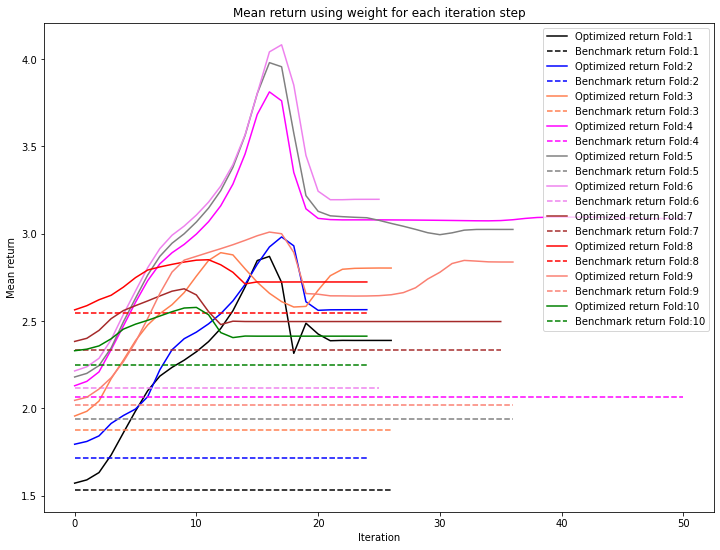

In [100]:
plt.figure(figsize=(12,9))
plt.title("Mean return using weight for each iteration step")
for fold, mean_r in enumerate(mean_r_fold):
    x = range(len(mean_r))
    plt.plot(x, mean_r, label=f'Optimized return Fold:{fold+1}', c=colors[fold])
    plt.plot(x, [benchmark_r_fold[fold]]*len(mean_r), label=f'Benchmark return Fold:{fold+1}', c=colors[fold], linestyle='dashed')
#     plt.plot(x, [eq_weighetd_r_fold[fold]]*len(mean_r), label=f'Equally weighted return Fold:{fold+1}', c=colors[fold], marker='.')
    plt.xlabel('Iteration')
    plt.ylabel('Mean return')
    plt.legend()
    plt.grid()
plt.show()

Single fold objective return optimization

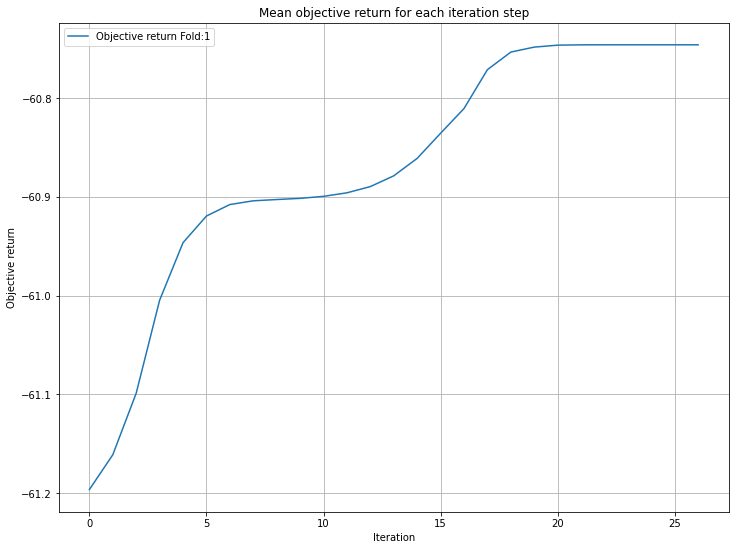

In [101]:
plt.figure(figsize=(12,9))
plt.title("Mean objective return for each iteration step")
for fold, mean_obj_r in enumerate(mean_obj_r_fold):
    x = range(len(mean_obj_r))
    plt.plot(x, mean_obj_r, label=f'Objective return Fold:{fold+1}')
    plt.xlabel('Iteration')
    plt.ylabel('Objective return')
    plt.legend()
    plt.grid()
    break
plt.show()

Multiple fold objective return optimization

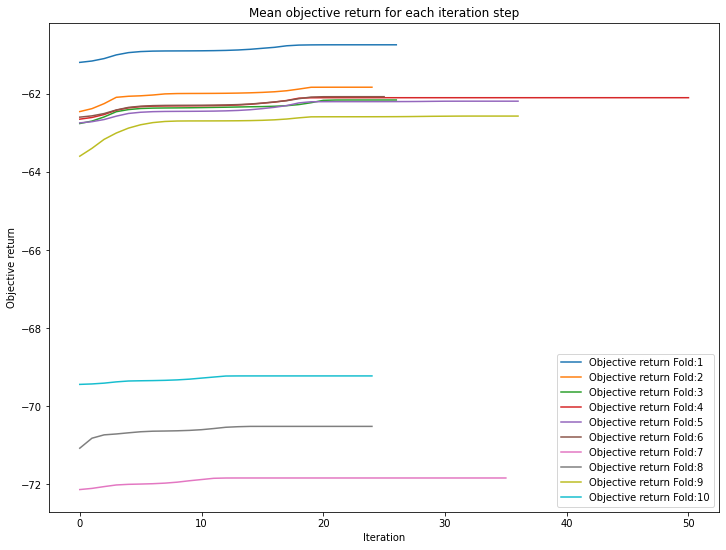

In [102]:
plt.figure(figsize=(12,9))
plt.title("Mean objective return for each iteration step")
for fold, mean_obj_r in enumerate(mean_obj_r_fold):
    x = range(len(mean_obj_r))
    plt.plot(x, mean_obj_r, label=f'Objective return Fold:{fold+1}')
    plt.xlabel('Iteration')
    plt.ylabel('Objective return')
    plt.legend()
    plt.grid()
plt.show()

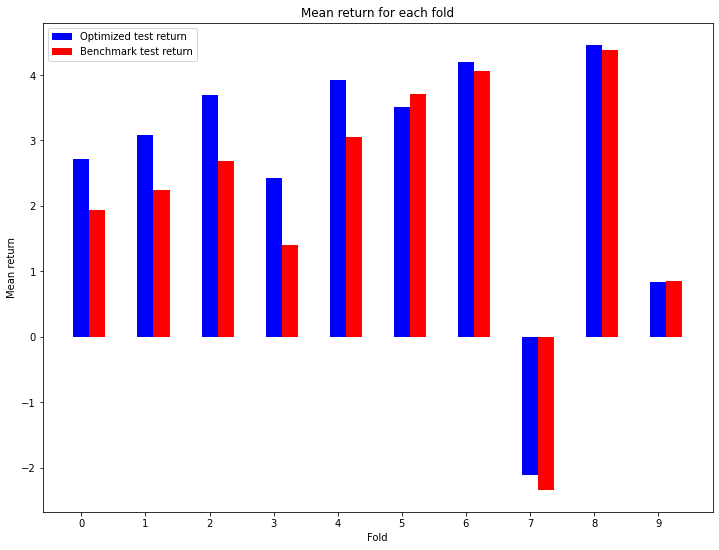

In [103]:
width = 0.25
br1 = np.arange(len(test_r_fold))
br2 = [x + width for x in br1]
plt.figure(figsize=(12,9))
plt.title("Mean return for each fold")
plt.xlabel('Fold')
plt.ylabel('Mean return')
plt.bar(br1, test_r_fold, label='Optimized test return', color='blue', width = 0.25)
plt.bar(br2, benchmark_test_r_fold, label='Benchmark test return', color='red', width = 0.25)
plt.xticks(br1)
# plt.grid()
plt.legend()
plt.show()

In [104]:
diff_r = np.array(test_r_fold) - np.array(benchmark_test_r_fold)
diff_r

array([ 0.76996765,  0.84966393,  1.00079981,  1.03628315,  0.86803628,
       -0.18975087,  0.13275947,  0.22257978,  0.07395866, -0.00347406])

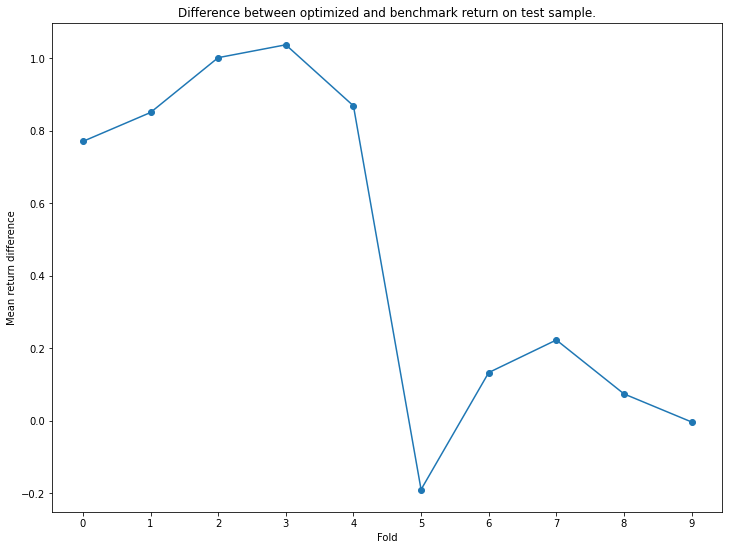

In [105]:
plt.figure(figsize=(12,9))
plt.title("Difference between optimized and benchmark return on test sample.")
x = range(10)
plt.plot(x, diff_r, marker='o')
plt.xlabel('Fold')
plt.ylabel('Mean return difference')
plt.xticks(x)
# plt.grid()
plt.show()

In [106]:
mean_return_above_benchmark = diff_r.sum()/num_folds
mean_return_above_benchmark

0.47608238074873166

# Single fold

In [95]:
size = monthly_return.shape[0]

train_size = int(size*0.7)
train_index =np.arange(train_size) 
test_index = np.arange(start=train_size, stop=size)

test_train = [(train_index, test_index)]
print(f'Train size: {train_size}, test size: {size-train_size}')
test_train

Train size: 142, test size: 61


[(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
          13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
          26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
          39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
          52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
          65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
          78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
          91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
         104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
         117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
         130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141]),
  array([142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
         155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
         168, 169, 170, 171, 172, 173, 17

In [130]:
# %%timeit
start = tm.time()
mean_obj_r_fold = []
mean_r_fold = []
benchmark_r_fold = []
theta_fold = []

test_r_fold = []
benchmark_test_r_fold =[]

benchmark_weights_fold = []

stocks_names = list(monthly_return.columns)

w_test_results = []
np.random.seed(123)
for train, test in test_train:    
    theta0 = np.random.rand(1, 3)
    
    train_btm = book_to_mkt_ratio.loc[train]
    train_me = mcap.loc[train]
    train_mom = lreturn.loc[train]
    train_return = monthly_return.loc[train]
    
    test_btm = book_to_mkt_ratio.loc[test]
    test_me = mcap.loc[test]
    test_mom = lreturn.loc[test]
    
    test_return = monthly_return.loc[test]
    
    #### TRAINING CHARACTERISTICS
    firm_characteristics, r, time, number_of_stocks = create_characteristics(train_me, train_mom, train_btm, train_return, stocks_names)
    
    # Creating a weight from a benchmark portifolio using uniform weighted    
    w_benchmark = np.ones(shape=(number_of_stocks, time))
    w_benchmark *= 1/number_of_stocks
    
    benchmark_weights_fold.append(w_benchmark)
    
    ### CREATING RETURNS TO COMPARE
    benchmark_mean_return = sum(sum(w_benchmark*r))/time
    benchmark_r_fold.append(benchmark_mean_return)
    
    opt_iter = 1
    sol, mean_obj_r, mean_r = optimizing_step(firm_characteristics, r, time, number_of_stocks, theta0, w_benchmark)
    sol_theta = sol.x
    
    ### SAVING PARAMETERS TO LOOKUP AFTER
    mean_r_fold.append(mean_r)
    mean_obj_r_fold.append(mean_obj_r)
    theta_fold.append(sol_theta)
    
    #### TESTING CHARACTERISTICS
    firm_characteristics_test, r_test, time_test, number_of_stocks = create_characteristics(test_me, test_mom, test_btm, test_return, stocks_names)
    firm_characteristics_test.fillna(method='ffill', inplace=True)

    #### CREATE BENCHMARK FOR TESTING
    w_benchmark_test = np.ones(shape=(number_of_stocks, time_test))
    w_benchmark_test *= 1/number_of_stocks

    benchmark_test_r = sum(sum(w_benchmark_test*r_test))/time_test
    benchmark_test_r_fold.append(benchmark_test_r)
    
    
    ### CREATE TEST WEIGHT AND FIND ITS RETURN
    w_test = np.empty(shape=(number_of_stocks, time_test))
    for i in range(number_of_stocks):
        firm_df = firm_characteristics_test[i].copy()
        firms_coeff = sol_theta.dot(firm_df.T)
        w_test[i] = w_benchmark_test[i] + (1/number_of_stocks)*firms_coeff
    
    w_test_results.append(w_test)
    test_r = sum(sum(w_test*r_test))/time_test
    test_r_fold.append(test_r)


end = tm.time()

Created firm characteristics matrix
Normalized firm characteristics
i:1, theta i: [0.69412759 0.26036287 0.1046067 ], f(theta):62.506089522435346
i:2, theta i: [0.67395901 0.03738544 0.07243693], f(theta):62.45905507822252
i:3, theta i: [ 0.62152668 -0.47809662  0.03754178], f(theta):62.380693627972875
i:4, theta i: [ 0.48575766 -1.67358534  0.01867274], f(theta):62.27135223541261
i:5, theta i: [ 0.33934315 -2.81673858  0.04378453], f(theta):62.21138719756841
i:6, theta i: [ 0.16236699 -4.04637789  0.06243279], f(theta):62.179943272052554
i:7, theta i: [-0.0160564  -5.15337989  0.07062895], f(theta):62.16670214524801
i:8, theta i: [-0.18407813 -6.07584585  0.07072043], f(theta):62.161481586342106
i:9, theta i: [-0.32161125 -6.71750452  0.06724517], f(theta):62.15966040244006
i:10, theta i: [-0.43123861 -7.11554881  0.0638509 ], f(theta):62.15882798719214
i:11, theta i: [-0.57985085 -7.50993043  0.06019162], f(theta):62.15778625093702
i:12, theta i: [-0.81356957 -7.95776919  0.05635528]

In [131]:
print(f"Duration: {end-start}s")

Duration: 33.06016445159912s


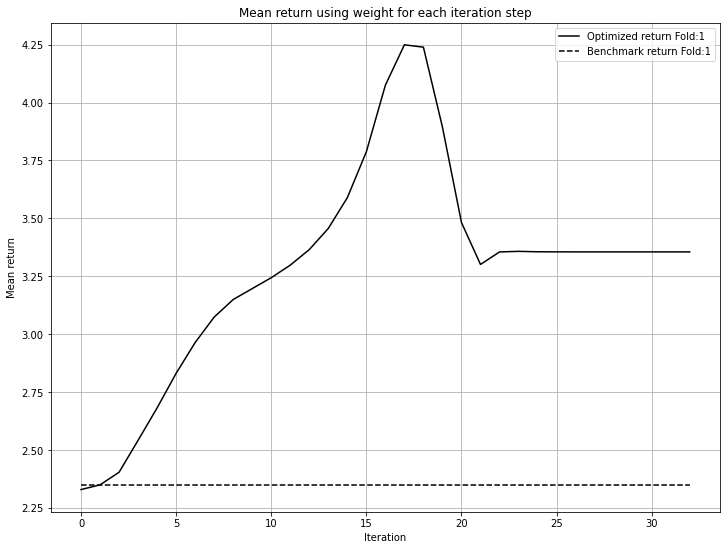

In [132]:
plt.figure(figsize=(12,9))
plt.title("Mean return using weight for each iteration step")
for fold, mean_r in enumerate(mean_r_fold):
    x = range(len(mean_r))
    plt.plot(x, mean_r, label=f'Optimized return Fold:{fold+1}', c='k')
    plt.plot(x, [benchmark_r_fold[fold]]*len(mean_r), label=f'Benchmark return Fold:{fold+1}', c='k', linestyle='dashed')
    plt.xlabel('Iteration')
    plt.ylabel('Mean return')
    plt.legend()
    plt.grid()
    break
plt.show()

In [133]:
min_i = 0
lowest = np.Inf
for i in range(1):
    w_describe = pd.DataFrame(w_test_results[i].T).describe()
    negative_sum = sum(w_describe.loc['min'][w_describe.loc['min'] < 0])
    if negative_sum < lowest:
        lowest=negative_sum
        min_i = i
    print(f"i:{i}, negative_sum:{negative_sum}")

i:0, negative_sum:-0.04814551257241412


In [134]:
w_describe = pd.DataFrame(w_test_results[min_i].T).describe()
w_describe

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
count,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,...,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000
mean,0.004448,0.004340,0.004310,0.004224,0.003812,0.004394,0.004035,0.004330,0.004363,0.004329,...,0.003671,0.004384,-0.002684,-0.002683,0.004359,0.003559,0.003559,0.004386,0.004056,0.004371
std,0.000015,0.000033,0.000032,0.000052,0.000799,0.000021,0.000112,0.000033,0.000024,0.000040,...,0.000190,0.000028,0.000648,0.000648,0.000025,0.000312,0.000311,0.000023,0.000048,0.000027
min,0.004415,0.004225,0.004235,0.004168,0.000035,0.004368,0.003767,0.004278,0.004336,0.004252,...,0.003230,0.004330,-0.004272,-0.004272,0.004304,0.002736,0.002735,0.004343,0.003943,0.004314
25%,0.004439,0.004325,0.004292,0.004201,0.003664,0.004384,0.003984,0.004301,0.004350,0.004294,...,0.003514,0.004359,-0.003078,-0.003078,0.004343,0.003416,0.003415,0.004371,0.004031,0.004357
50%,0.004449,0.004335,0.004309,0.004210,0.004183,0.004390,0.004049,0.004327,0.004355,0.004321,...,0.003706,0.004387,-0.002599,-0.002600,0.004357,0.003638,0.003637,0.004384,0.004070,0.004366
75%,0.004456,0.004351,0.004323,0.004222,0.004264,0.004397,0.004130,0.004352,0.004365,0.004360,...,0.003822,0.004396,-0.002318,-0.002318,0.004371,0.003812,0.003811,0.004391,0.004087,0.004375
max,0.004488,0.004435,0.004402,0.004421,0.004438,0.004471,0.004212,0.004415,0.004449,0.004408,...,0.004029,0.004440,-0.001325,-0.001325,0.004423,0.003928,0.003928,0.004461,0.004169,0.004461


In [135]:
print(test_r_fold)
print(benchmark_test_r_fold)

[1.688526782342991]
[1.605073432486344]


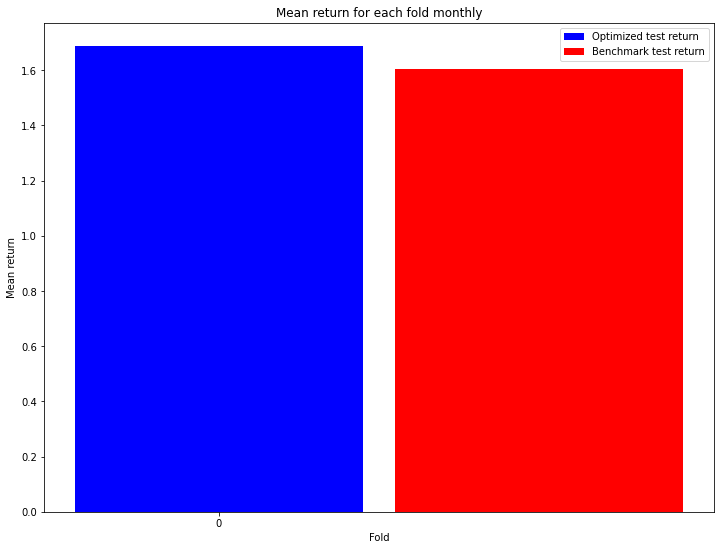

In [136]:
width = 0.1
br1 = np.arange(len(test_r_fold))
br2 = [x + width for x in br1]
plt.figure(figsize=(12,9))
plt.title("Mean return for each fold monthly")
plt.xlabel('Fold')
plt.ylabel('Mean return')
plt.bar(br1, test_r_fold, label='Optimized test return', color='blue', width = 0.09)
plt.bar(br2, benchmark_test_r_fold, label='Benchmark test return', color='red', width = 0.09)
plt.xticks(br1)
# plt.grid()
plt.legend()
plt.show()

In [102]:
diff_r = np.array(test_r_fold) - np.array(benchmark_test_r_fold)
diff_r

array([0.08345335])

In [103]:
mean_return_above_benchmark = diff_r.sum()/1
mean_return_above_benchmark

0.08345334985664699

## Using only top 50 mcap companies

In [121]:
top50_mcap = mcap.describe().loc['mean'].sort_values(ascending=False)[:150]
top50_stock_names = list(top50_mcap.index)

In [122]:
size = monthly_return.shape[0]

train_size = int(size*0.7)
train_index =np.arange(train_size) 
test_index = np.arange(start=train_size, stop=size)

test_train = [(train_index, test_index)]
print(f'Train size: {train_size}, test size: {size-train_size}')
test_train

Train size: 142, test size: 61


[(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
          13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
          26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
          39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
          52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
          65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
          78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
          91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
         104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
         117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
         130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141]),
  array([142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
         155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
         168, 169, 170, 171, 172, 173, 17

In [123]:
# %%timeit
start = tm.time()
mean_obj_r_fold = []
mean_r_fold = []
benchmark_r_fold = []
theta_fold = []

test_r_fold = []
benchmark_test_r_fold =[]

benchmark_weights_fold = []

stocks_names = top50_stock_names

w_test_results = []
np.random.seed(123)
for train, test in test_train:    
    theta0 = np.random.rand(1, 3)
    
    train_btm = book_to_mkt_ratio.loc[train]
    train_me = mcap.loc[train]
    train_mom = lreturn.loc[train]
    train_return = monthly_return.loc[train]
    
    test_btm = book_to_mkt_ratio.loc[test]
    test_me = mcap.loc[test]
    test_mom = lreturn.loc[test]
    
    test_return = monthly_return.loc[test]
    
    #### TRAINING CHARACTERISTICS
    firm_characteristics, r, time, number_of_stocks = create_characteristics(train_me, train_mom, train_btm, train_return, stocks_names)
    
    # Creating a weight from a benchmark portifolio using uniform weighted    
    w_benchmark = np.ones(shape=(number_of_stocks, time))
    w_benchmark *= 1/number_of_stocks
    
    benchmark_weights_fold.append(w_benchmark)
    
    ### CREATING RETURNS TO COMPARE
    benchmark_mean_return = sum(sum(w_benchmark*r))/time
    benchmark_r_fold.append(benchmark_mean_return)
    
    opt_iter = 1
    sol, mean_obj_r, mean_r = optimizing_step(firm_characteristics, r, time, number_of_stocks, theta0, w_benchmark)
    sol_theta = sol.x
    
    ### SAVING PARAMETERS TO LOOKUP AFTER
    mean_r_fold.append(mean_r)
    mean_obj_r_fold.append(mean_obj_r)
    theta_fold.append(sol_theta)
    
    #### TESTING CHARACTERISTICS
    firm_characteristics_test, r_test, time_test, number_of_stocks = create_characteristics(test_me, test_mom, test_btm, test_return, stocks_names)
    firm_characteristics_test.fillna(method='ffill', inplace=True)

    #### CREATE BENCHMARK FOR TESTING
    w_benchmark_test = np.ones(shape=(number_of_stocks, time_test))
    w_benchmark_test *= 1/number_of_stocks

    benchmark_test_r = sum(sum(w_benchmark_test*r_test))/time_test
    benchmark_test_r_fold.append(benchmark_test_r)
    
    
    ### CREATE TEST WEIGHT AND FIND ITS RETURN
    w_test = np.empty(shape=(number_of_stocks, time_test))
    for i in range(number_of_stocks):
        firm_df = firm_characteristics_test[i].copy()
        firms_coeff = sol_theta.dot(firm_df.T)
        w_test[i] = w_benchmark_test[i] + (1/number_of_stocks)*firms_coeff
    
    w_test_results.append(w_test)
    test_r = sum(sum(w_test*r_test))/time_test
    test_r_fold.append(test_r)


end = tm.time()

Created firm characteristics matrix
Normalized firm characteristics
i:1, theta i: [0.69084996 0.28773886 0.3056811 ], f(theta):38.05254777650324
i:2, theta i: [0.66426618 0.29471172 0.35148966], f(theta):38.03078287801067
i:3, theta i: [0.57993719 0.31669105 0.36034265], f(theta):38.02454345766702
i:4, theta i: [-0.26908095  0.53827234  0.38236435], f(theta):37.97451380504222
i:5, theta i: [-1.77335065  0.93149409  0.38957409], f(theta):37.88273341720763
i:6, theta i: [-4.5491626   1.65882449  0.38556954], f(theta):37.72031690685172
i:7, theta i: [-11.09897248   3.38221711   0.38055815], f(theta):37.47781832601034
i:8, theta i: [-18.1514716    5.24455914   0.37559886], f(theta):37.35949941903397
i:9, theta i: [-21.51738361   6.13379748   0.37329484], f(theta):37.34409987249567
i:10, theta i: [-21.84507543   6.21750659   0.37278925], f(theta):37.34396380242357
i:11, theta i: [-21.85066009   6.21576899   0.37255757], f(theta):37.34395130728045
i:12, theta i: [-21.8502079    6.20835821   

In [124]:
print(f"Duration: {end-start}s")

Duration: 17.072835683822632s


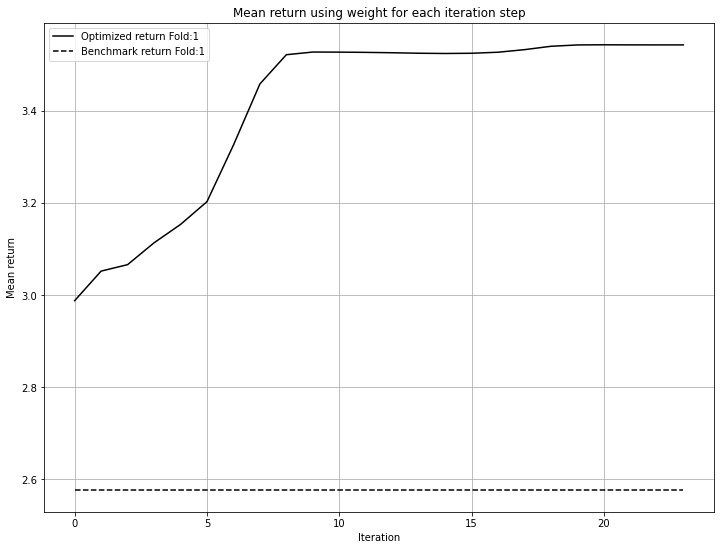

In [125]:
plt.figure(figsize=(12,9))
plt.title("Mean return using weight for each iteration step")
for fold, mean_r in enumerate(mean_r_fold):
    x = range(len(mean_r))
    plt.plot(x, mean_r, label=f'Optimized return Fold:{fold+1}', c='k')
    plt.plot(x, [benchmark_r_fold[fold]]*len(mean_r), label=f'Benchmark return Fold:{fold+1}', c='k', linestyle='dashed')
    plt.xlabel('Iteration')
    plt.ylabel('Mean return')
    plt.legend()
    plt.grid()
    break
plt.show()

In [126]:
min_i = 0
lowest = np.Inf
for i in range(1):
    w_describe = pd.DataFrame(w_test_results[i].T).describe()
    negative_sum = sum(w_describe.loc['min'][w_describe.loc['min'] < 0])
    if negative_sum < lowest:
        lowest=negative_sum
        min_i = i
    print(f"i:{i}, negative_sum:{negative_sum}")

i:0, negative_sum:-0.03775542440284815


In [127]:
w_describe = pd.DataFrame(w_test_results[min_i].T).describe()
w_describe

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
count,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,...,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000
mean,-0.007825,-0.007823,-0.003349,-0.003352,0.001481,0.001496,0.002658,0.002658,0.005623,0.003131,...,0.007784,0.007590,0.007514,0.007575,0.007595,0.007593,0.007483,0.007661,0.007660,0.007640
std,0.002255,0.002255,0.000995,0.000995,0.000874,0.000881,0.000340,0.000334,0.000656,0.001139,...,0.000222,0.000181,0.000120,0.000073,0.000348,0.000198,0.000181,0.000154,0.000117,0.000138
min,-0.012805,-0.012804,-0.005849,-0.005850,0.000096,0.000037,0.001898,0.001929,0.004448,-0.000230,...,0.007425,0.006563,0.007118,0.007163,0.006231,0.006603,0.006785,0.007322,0.007246,0.007252
25%,-0.009685,-0.009645,-0.003903,-0.003911,0.000758,0.000773,0.002409,0.002409,0.005116,0.002568,...,0.007683,0.007572,0.007440,0.007570,0.007516,0.007547,0.007423,0.007592,0.007615,0.007584
50%,-0.007335,-0.007344,-0.003206,-0.003203,0.001245,0.001249,0.002705,0.002697,0.005550,0.003453,...,0.007749,0.007620,0.007533,0.007592,0.007584,0.007598,0.007472,0.007635,0.007656,0.007640
75%,-0.006058,-0.006061,-0.002857,-0.002865,0.002214,0.002211,0.002916,0.002920,0.005923,0.003771,...,0.007837,0.007659,0.007595,0.007605,0.007727,0.007645,0.007556,0.007710,0.007708,0.007703
max,-0.003829,-0.003822,-0.001382,-0.001392,0.003227,0.003201,0.003272,0.003252,0.007873,0.004995,...,0.009135,0.008178,0.007821,0.007661,0.008834,0.008285,0.008124,0.008300,0.007946,0.008098


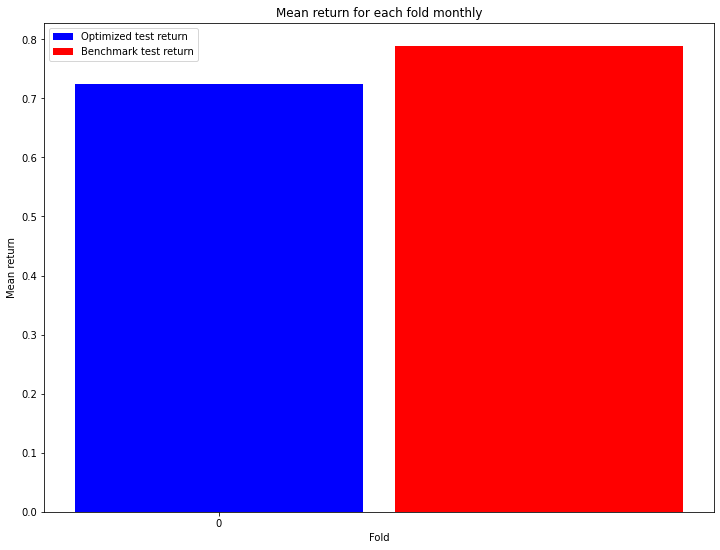

In [128]:
width = 0.1
br1 = np.arange(len(test_r_fold))
br2 = [x + width for x in br1]
plt.figure(figsize=(12,9))
plt.title("Mean return for each fold monthly")
plt.xlabel('Fold')
plt.ylabel('Mean return')
plt.bar(br1, test_r_fold, label='Optimized test return', color='blue', width = 0.09)
plt.bar(br2, benchmark_test_r_fold, label='Benchmark test return', color='red', width = 0.09)
plt.xticks(br1)
# plt.grid()
plt.legend()
plt.show()

In [129]:
diff_r = np.array(test_r_fold) - np.array(benchmark_test_r_fold)
diff_r

array([-0.06430274])

## OOS Rep-Holdout 

In [54]:
size = monthly_return.shape[0]
np.random.seed(123)
number_of_test = 10
train_indexes = (size*np.random.rand(number_of_test)).astype(int)

start = tm.time()
mean_obj_r_fold = []
mean_r_fold = []
benchmark_r_fold = []
theta_fold = []

test_r_fold = []
test_r_fold_std = []

benchmark_test_r_fold =[]
benchmark_test_r_fold_std =[]

benchmark_weights_fold = []

w_test_results = []
    
for index in train_indexes:
    train_index =np.arange(index) 
    test_index = np.arange(start=index, stop=size)

    test_train = [(train_index, test_index)]
    print(f'Train size: {index}, test size: {size-index}')
    
    stocks_names = list(monthly_return.columns)
    
    for train, test in test_train:    
        theta0 = np.random.rand(1, 3)

        train_btm = book_to_mkt_ratio.loc[train]
        train_me = mcap.loc[train]
        train_mom = lreturn.loc[train]
        train_return = monthly_return.loc[train]

        test_btm = book_to_mkt_ratio.loc[test]
        test_me = mcap.loc[test]
        test_mom = lreturn.loc[test]

        test_return = monthly_return.loc[test]

        #### TRAINING CHARACTERISTICS
        firm_characteristics, r, time, number_of_stocks = create_characteristics(train_me, train_mom, train_btm, train_return, stocks_names)

        # Creating a weight from a benchmark portifolio using uniform weighted    
        w_benchmark = np.ones(shape=(number_of_stocks, time))
        w_benchmark *= 1/number_of_stocks

        benchmark_weights_fold.append(w_benchmark)

        ### CREATING RETURNS TO COMPARE
        benchmark_mean_return = sum(sum(w_benchmark*r))/time
        benchmark_r_fold.append(benchmark_mean_return)

        opt_iter = 1
        sol, mean_obj_r, mean_r = optimizing_step(firm_characteristics, r, time, number_of_stocks, theta0, w_benchmark)
        sol_theta = sol.x

        ### SAVING PARAMETERS TO LOOKUP AFTER
        mean_r_fold.append(mean_r)
        mean_obj_r_fold.append(mean_obj_r)
        theta_fold.append(sol_theta)

        #### TESTING CHARACTERISTICS
        firm_characteristics_test, r_test, time_test, number_of_stocks = create_characteristics(test_me, test_mom, test_btm, test_return, stocks_names)
        firm_characteristics_test.fillna(method='ffill', inplace=True)

        #### CREATE BENCHMARK FOR TESTING
        w_benchmark_test = np.ones(shape=(number_of_stocks, time_test))
        w_benchmark_test *= 1/number_of_stocks
        
        benchmark_r_test_series=pd.Series(sum(w_benchmark_test*r_test)).describe()
    
        benchmark_test_r_fold.append(benchmark_r_test_series['mean'])
        benchmark_test_r_fold_std.append(benchmark_r_test_series['std'])


        ### CREATE TEST WEIGHT AND FIND ITS RETURN
        w_test = np.empty(shape=(number_of_stocks, time_test))
        for i in range(number_of_stocks):
            firm_df = firm_characteristics_test[i].copy()
            firms_coeff = sol_theta.dot(firm_df.T)
            w_test[i] = w_benchmark_test[i] + (1/number_of_stocks)*firms_coeff

        w_test_results.append(w_test)
        r_test_series = pd.Series(sum(w_test*r_test)).describe()
    
        test_r_fold.append(r_test_series['mean'])
        test_r_fold_std.append(r_test_series['std'])

end = tm.time()


Train size: 141, test size: 62
Created firm characteristics matrix
Normalized firm characteristics
i:1, theta i: [0.34317813 0.72904982 0.43885638], f(theta):2915.8315400965243
i:2, theta i: [0.36697888 0.63844857 0.43950359], f(theta):2265.4707972850624
i:3, theta i: [0.37775044 0.21977699 0.44114318], f(theta):1326.1582351588231
i:4, theta i: [ 0.37324214 -0.33378843  0.44283675], f(theta):839.746449149073
i:5, theta i: [ 0.34872602 -1.06779725  0.44489731], f(theta):528.1038466924035
i:6, theta i: [ 0.30330269 -1.91146491  0.44720741], f(theta):344.44267471756734
i:7, theta i: [ 0.2319245  -2.88606039  0.44986018], f(theta):232.70183601644283
i:8, theta i: [ 0.13108779 -3.9873882   0.45286785], f(theta):165.58121619473187
i:9, theta i: [-2.18754113e-03 -5.22949814e+00  4.56285841e-01], f(theta):125.1026726461822
i:10, theta i: [-0.17226532 -6.62402965  0.46015806], f(theta):100.77847626038894
i:11, theta i: [-0.38318139 -8.18603817  0.46453556], f(theta):86.20955215400372
i:12, thet

i:52, theta i: [-20.25703328  -4.87786796  -0.29639015], f(theta):62.24426026205591
Created firm characteristics matrix
Normalized firm characteristics
Train size: 46, test size: 157
Created firm characteristics matrix
Normalized firm characteristics
i:1, theta i: [ 0.18175306  0.16627894 -0.4784067 ], f(theta):62.85832010763033
i:2, theta i: [ 0.15942714 -0.01786123 -0.46990827], f(theta):62.824509613415856
i:3, theta i: [ 0.10543586 -0.41003483 -0.4498425 ], f(theta):62.76400858930217
i:4, theta i: [-0.03240172 -1.3004785  -0.39998731], f(theta):62.66970142630879
i:5, theta i: [-0.24832772 -2.5412033  -0.32498092], f(theta):62.59897482749951
i:6, theta i: [-0.46098412 -3.62787689 -0.2558535 ], f(theta):62.56940675897194
i:7, theta i: [-0.65890151 -4.52023683 -0.19778488], f(theta):62.55878191122787
i:8, theta i: [-0.78770537 -4.99479207 -0.16698673], f(theta):62.5565113071184
i:9, theta i: [-0.87322445 -5.20930526 -0.15367933], f(theta):62.55563954428013
i:10, theta i: [-1.01541449 -

i:16, theta i: [-34.2922584   -5.75905781  -0.18257448], f(theta):62.68793717661788
i:17, theta i: [-34.29658774  -5.74921395  -0.18260701], f(theta):62.68792156098481
i:18, theta i: [-34.3065067   -5.74032644  -0.18264145], f(theta):62.68789184040005
i:19, theta i: [-34.4090108   -5.69240845  -0.18286643], f(theta):62.68766525008678
i:20, theta i: [-34.60105241  -5.65417523  -0.18310891], f(theta):62.68734593357856
i:21, theta i: [-34.93189091  -5.64240944  -0.18336543], f(theta):62.68680098123956
i:22, theta i: [-35.50268718  -5.67354702  -0.18364293], f(theta):62.68586795496376
i:23, theta i: [-36.51804684  -5.79366864  -0.18392464], f(theta):62.68438786511415
i:24, theta i: [-37.93836134  -6.04484842  -0.18400985], f(theta):62.68293237827879
i:25, theta i: [-38.32105113  -6.20147614  -0.18377423], f(theta):62.68245836674313
i:26, theta i: [-38.26457917  -6.29545001  -0.18348696], f(theta):62.68229845937914
i:27, theta i: [-38.16338121  -6.29725486  -0.18343183], f(theta):62.6822912

i:28, theta i: [-16.71710115  -5.82443858   0.14263648], f(theta):62.01203833102706
i:29, theta i: [-20.00168365  -5.91045585   0.13750094], f(theta):61.99872749730462
i:30, theta i: [-24.55780195  -6.0697168    0.10325912], f(theta):61.9845363821427
i:31, theta i: [-25.38046333  -6.13087167   0.07836442], f(theta):61.98186229696585
i:32, theta i: [-25.0085212   -6.15197824   0.06682891], f(theta):61.98139935207307
i:33, theta i: [-24.70641471  -6.1550684    0.06569522], f(theta):61.98136295581568
i:34, theta i: [-24.62687989  -6.15065918   0.06590182], f(theta):61.98136138238975
i:35, theta i: [-24.6329084   -6.15215762   0.06593194], f(theta):61.981361370175904
Created firm characteristics matrix
Normalized firm characteristics
Train size: 97, test size: 106
Created firm characteristics matrix
Normalized firm characteristics
i:1, theta i: [ 0.42542966  0.3118603  -0.58364853], f(theta):62.775014583312796
i:2, theta i: [ 0.402357    0.10043494 -0.58355545], f(theta):62.73277862051771


i:29, theta i: [-22.93107561  -5.40642829  -0.39363354], f(theta):62.053128806880395
i:30, theta i: [-22.95718519  -5.41980339  -0.40187622], f(theta):62.05305053996061
i:31, theta i: [-23.0366712   -5.40377252  -0.40571446], f(theta):62.05302211953118
i:32, theta i: [-23.15539862  -5.36802574  -0.40731738], f(theta):62.05300285523201
i:33, theta i: [-23.24379757  -5.34326491  -0.40660682], f(theta):62.05299712536317
i:34, theta i: [-23.24770388  -5.33958967  -0.40593033], f(theta):62.052996692854954
i:35, theta i: [-23.24415425  -5.33936009  -0.40576705], f(theta):62.052996678170906
Created firm characteristics matrix
Normalized firm characteristics


In [55]:
print(f"Duration: {end-start}s")

Duration: 470.56142497062683s


In [74]:
min_i = 0
lowest = np.Inf
usable_fold_indexes = []
for i in range(10):
    w_describe = pd.DataFrame(w_test_results[i].T).describe()
    negative_sum = sum(w_describe.loc['min'][w_describe.loc['min'] < 0])
    if negative_sum < lowest:
        lowest=negative_sum
        min_i = i
    
    if negative_sum > -0.1:
        print(f"Fold:{i}, Usable fold to analyse.")
        usable_fold_indexes.append(i)
        
    print(f"Fold:{i}, negative_sum:{negative_sum} \n")

Fold:0, Usable fold to analyse.
Fold:0, negative_sum:-0.03621053230263926 

Fold:1, negative_sum:-0.48024017024780996 

Fold:2, negative_sum:-0.151028758366889 

Fold:3, negative_sum:-2.126441427768198 

Fold:4, Usable fold to analyse.
Fold:4, negative_sum:-0.061870731771884166 

Fold:5, negative_sum:-0.598813475616578 

Fold:6, Usable fold to analyse.
Fold:6, negative_sum:-0.004911401355266008 

Fold:7, Usable fold to analyse.
Fold:7, negative_sum:-0.04771528118099999 

Fold:8, negative_sum:-0.532897855726819 

Fold:9, negative_sum:-0.7210318071696129 



In [44]:
for i, index in enumerate(train_indexes):
    
    print(f'Fold:{i}, Train size: {index}, test size: {size-index}')

Fold:0, Train size: 141, test size: 62
Fold:1, Train size: 58, test size: 145
Fold:2, Train size: 46, test size: 157
Fold:3, Train size: 111, test size: 92
Fold:4, Train size: 146, test size: 57
Fold:5, Train size: 85, test size: 118
Fold:6, Train size: 199, test size: 4
Fold:7, Train size: 139, test size: 64
Fold:8, Train size: 97, test size: 106
Fold:9, Train size: 79, test size: 124


In [27]:
colors ={
    0:'black',
    1:'blue',
    2:'coral',
    3:'magenta',
    4:'grey',
    5:'violet',
    6:'brown',
    7:'red',
    8:'salmon',
    9:'green'
}

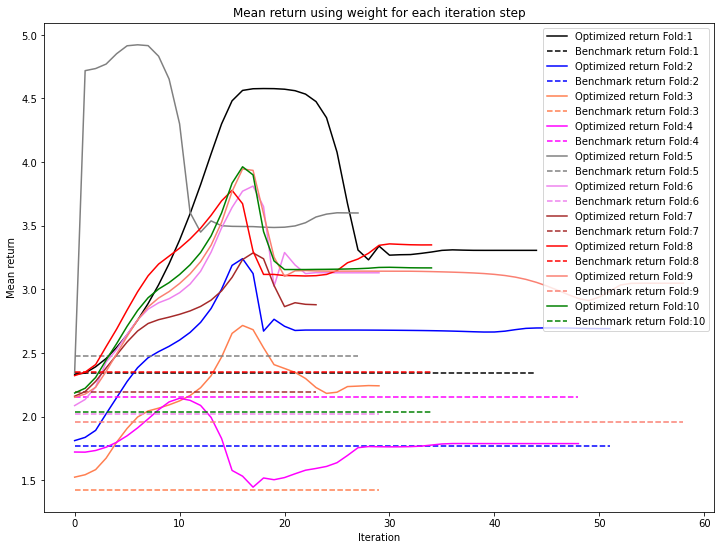

In [28]:
plt.figure(figsize=(12,9))
plt.title("Mean return using weight for each iteration step")
for fold, mean_r in enumerate(mean_r_fold):
    x = range(len(mean_r))
    plt.plot(x, mean_r, label=f'Optimized return Fold:{fold+1}', c=colors[fold])
    plt.plot(x, [benchmark_r_fold[fold]]*len(mean_r), label=f'Benchmark return Fold:{fold+1}', c=colors[fold], linestyle='dashed')
    plt.xlabel('Iteration')
    plt.ylabel('Mean return')
    plt.legend()
    plt.grid()
plt.show()

In [86]:
print(f"Optimized returns:\n{test_r_fold} \n")
print(f"Bench returns:\n{benchmark_test_r_fold}")

Optimized returns:
[1.7595927955773545, 2.632119221970379, 2.764652675069098, 2.898543612316031, 1.2121193760084041, 2.4181943941696673, -1.3478770840937546, 1.7629389572266525, 2.456259677300917, 2.392400598610402] 

Bench returns:
[1.6370817214749531, 2.2668838530728754, 2.328954720995566, 2.0903120946670306, 1.2248510452331276, 2.1984070363019805, -1.252086163961371, 1.641722208342492, 2.2782074930639626, 2.17933828208614]


In [87]:
print(f"Usable indexes: {usable_fold_indexes} \n")
print(f"Optimized returns:\n{np.array(test_r_fold)[usable_fold_indexes]} \n")
print(f"Bench returns:\n{np.array(benchmark_test_r_fold)[usable_fold_indexes]}")

Usable indexes: [0, 4, 6, 7] 

Optimized returns:
[ 1.7595928   1.21211938 -1.34787708  1.76293896] 

Bench returns:
[ 1.63708172  1.22485105 -1.25208616  1.64172221]


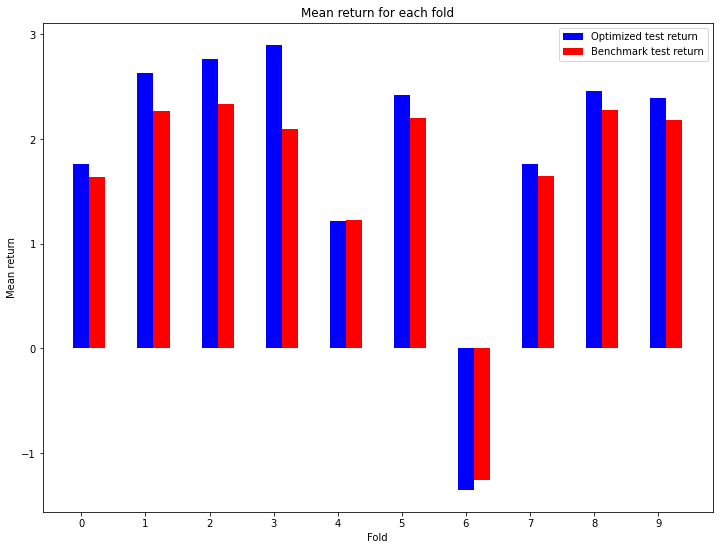

In [89]:
width = 0.25
br1 = np.arange(len(test_r_fold))
br2 = [x + width for x in br1]
plt.figure(figsize=(12,9))
plt.title("Mean return for each fold")
plt.xlabel('Fold')
plt.ylabel('Mean return')
plt.bar(br1, test_r_fold, label='Optimized test return', color='blue', width = 0.25)
plt.bar(br2, benchmark_test_r_fold, label='Benchmark test return', color='red', width = 0.25)
plt.xticks(br1)
# plt.grid()
plt.legend()
plt.show()

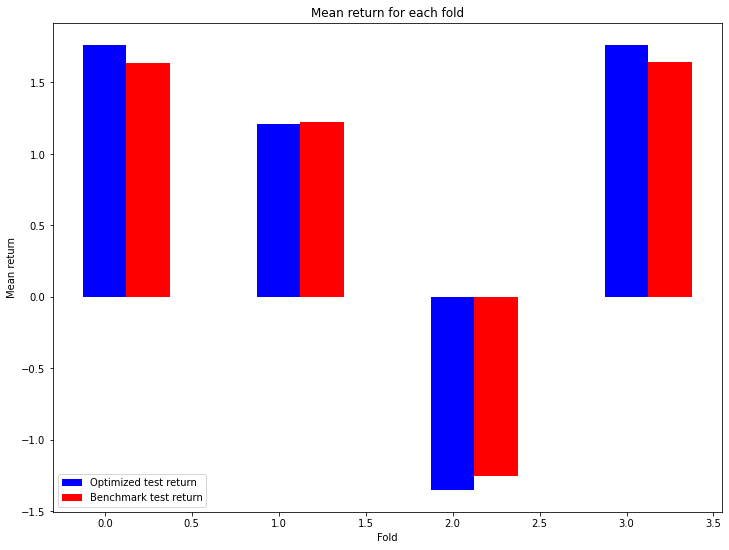

In [88]:
width = 0.25
br1 = np.arange(len(np.array(benchmark_test_r_fold)[usable_fold_indexes]))
br2 = [x + width for x in br1]
plt.figure(figsize=(12,9))
plt.title("Mean return for each fold")
plt.xlabel('Fold')
plt.ylabel('Mean return')
plt.bar(br1, np.array(test_r_fold)[usable_fold_indexes], label='Optimized test return', color='blue', width = 0.25)
plt.bar(br2, np.array(benchmark_test_r_fold)[usable_fold_indexes], label='Benchmark test return', color='red', width = 0.25)
# plt.xticks(br1)
# plt.grid()
plt.legend()
plt.show()

In [94]:
diff_r = np.array(test_r_fold) - np.array(benchmark_test_r_fold)
diff_r

array([ 0.12251107,  0.36523537,  0.43569795,  0.80823152, -0.01273167,
        0.21978736, -0.09579092,  0.12121675,  0.17805218,  0.21306232])

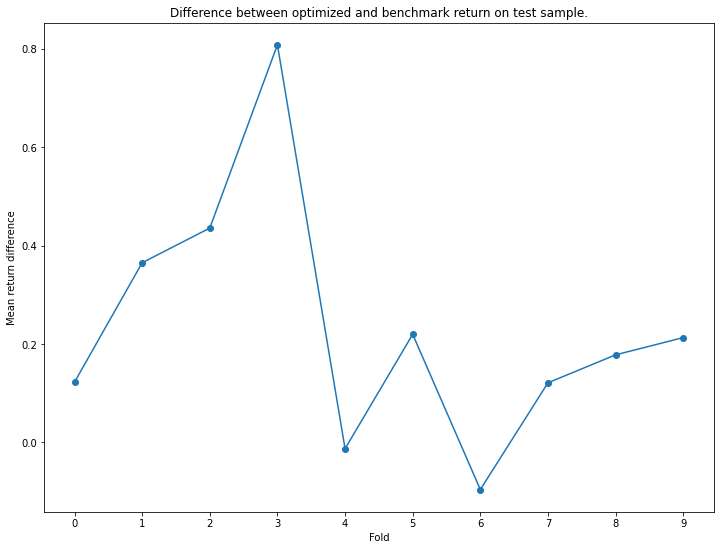

In [95]:
plt.figure(figsize=(12,9))
plt.title("Difference between optimized and benchmark return on test sample.")
x = range(len(diff_r))
plt.plot(x, diff_r, marker='o')
plt.xlabel('Fold')
plt.ylabel('Mean return difference')
plt.xticks(x)
# plt.grid()
plt.show()

In [96]:
diff_series = pd.Series(diff_r).describe()
mean_return_above_benchmark = diff_series['mean']
std_return_above_benchmark = diff_series['std']

print(f"Mean: {mean_return_above_benchmark}, std: {std_return_above_benchmark}")


Mean: 0.23552719328783933, std: 0.2552084666829172


In [97]:
diff_r = np.array(test_r_fold)[usable_fold_indexes] - np.array(benchmark_test_r_fold)[usable_fold_indexes]
diff_r

array([ 0.12251107, -0.01273167, -0.09579092,  0.12121675])

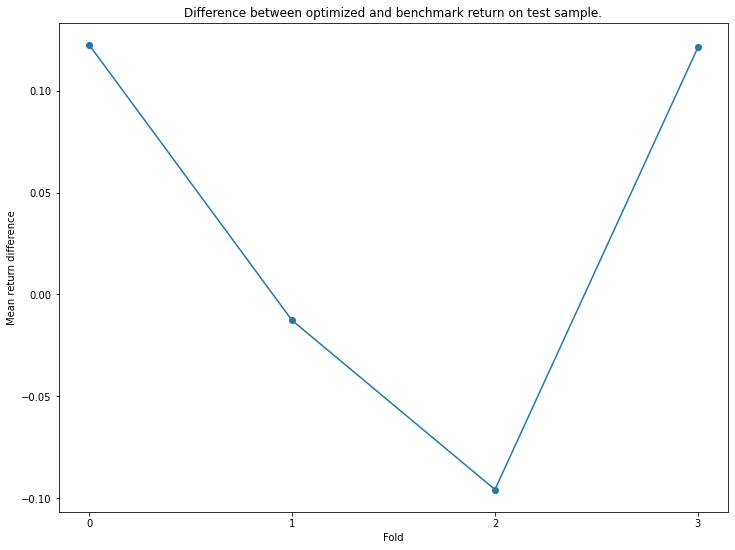

In [98]:
plt.figure(figsize=(12,9))
plt.title("Difference between optimized and benchmark return on test sample.")
x = range(len(diff_r))
plt.plot(x, diff_r, marker='o')
plt.xlabel('Fold')
plt.ylabel('Mean return difference')
plt.xticks(x)
# plt.grid()
plt.show()

In [99]:
diff_series = pd.Series(diff_r).describe()
mean_return_above_benchmark = diff_series['mean']
std_return_above_benchmark = diff_series['std']

print(f"Mean: {mean_return_above_benchmark}, std: {std_return_above_benchmark}")


Mean: 0.03380130840736367, std: 0.10719195471773571
